### Instalar bibliotecas

In [1]:
# Instalar bibliotecas ( necess√°rio)
!pip install mlflow evidently scikit-learn pandas numpy matplotlib seaborn papermill

# Importar pacotes principais
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from evidently.report import Report
from evidently.metrics import DataDriftTable
import pickle



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


 Garantir que o ambiente est√° pronto para rodar os modelos.

### Configurar MLflow para rastreamento de experimentos

In [2]:
# Importando o MLflow
import mlflow
import mlflow.sklearn
import os

# Definindo um novo diret√≥rio para armazenar os logs dos experimentos
caminho_logs = "E:\Mestrado UFCG\Semestre 2024.2\Dados\MLOps dropout\EXperimentos_MLflow"

# Criando o diret√≥rio se ele n√£o existir
os.makedirs(caminho_logs, exist_ok=True)

# Configurando o MLflow para armazenar logs nesse diret√≥rio
mlflow.set_tracking_uri(f"file:///{caminho_logs}")

# Criando um novo experimento (se j√° existir, ele usa o existente)
mlflow.set_experiment("Evasao_UFCG")

# Exibir a configura√ß√£o para garantir que est√° correto
print(f"Tracking URI: {mlflow.get_tracking_uri()}")

2025/04/25 13:33:01 INFO mlflow.tracking.fluent: Experiment with name 'Evasao_UFCG' does not exist. Creating a new experiment.


Tracking URI: file:///E:\Mestrado UFCG\Semestre 2024.2\Dados\MLOps dropout\EXperimentos_MLflow


### Carregar os dados as tabelas relevantes

In [3]:
import pandas as pd
import os
import mlflow

# Definindo caminhos
caminho_base = "E:/Mestrado UFCG/Semestre 2024.2/Dados/Tabelas_0/"
tables = ["alunos", "tabela_motivo_evasao", "tabela_dados_ingresso", "tabela_dados_pessoais", "matriculas"]

# Iniciar Experimento MLflow
mlflow.set_experiment("Carregamento de Dados UFCG")

with mlflow.start_run():
    # Log do in√≠cio do carregamento usando m√©trica em vez de par√¢metro fixo
    mlflow.log_metric("status_iniciando", 1)

    dados = {}
    
    for table in tables:
        caminho = os.path.join(caminho_base, f"{table}.csv")
        try:
            # Detectar delimitador correto
            with open(caminho, "r", encoding="utf-8") as f:
                primeira_linha = f.readline()
                if ";" in primeira_linha:
                    delimitador = ";"
                elif "," in primeira_linha:
                    delimitador = ","
                elif "\t" in primeira_linha:
                    delimitador = "\t"
                else:
                    delimitador = ","  # Padr√£o caso n√£o detecte

            # Carregar CSV com delimitador correto
            df = pd.read_csv(caminho, delimiter=delimitador, encoding="utf-8")
            
            # Verifica se carregou corretamente
            if df.shape[1] == 1:
                print(f" Aten√ß√£o: {table} foi carregada com apenas 1 coluna! Pode haver erro no delimitador.")
            
            dados[table] = df
            print(f"{table} carregada com sucesso! ({df.shape[0]} linhas, {df.shape[1]} colunas)")
        except Exception as e:
            print(f"Erro ao carregar {table}: {e}")
            mlflow.log_param(f"erro_{table}", str(e))  # Log do erro no MLflow

    # Usar m√©trica ao inv√©s de par√¢metro para evitar erro no MLflow
    mlflow.log_metric("status_carregamento_finalizado", 1)

    print(" Carregamento finalizado.")


2025/04/25 13:33:11 INFO mlflow.tracking.fluent: Experiment with name 'Carregamento de Dados UFCG' does not exist. Creating a new experiment.


alunos carregada com sucesso! (3761 linhas, 22 colunas)
tabela_motivo_evasao carregada com sucesso! (3761 linhas, 2 colunas)
tabela_dados_ingresso carregada com sucesso! (3761 linhas, 4 colunas)
tabela_dados_pessoais carregada com sucesso! (3761 linhas, 5 colunas)
matriculas carregada com sucesso! (182660 linhas, 10 colunas)
 Carregamento finalizado.


### Pr√©-processamento

###  Verificar as primeiras linhas das tabelas

In [4]:
# Explorando as tabelas carregadas
for nome_tabela, df in dados.items():
    print(f"\n Explorando a tabela: {nome_tabela}")
    print(df.info())  # Estrutura geral do DataFrame
    print(df.head())  # Primeiras linhas para visualizar os dados
    print("-" * 80)



 Explorando a tabela: alunos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3761 entries, 0 to 3760
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   MATRICULA                   3761 non-null   int64  
 1   ID_CIDADAO                  3743 non-null   float64
 2   NOME                        3761 non-null   object 
 3   IDADE                       3761 non-null   int64  
 4   E-MAIL                      3263 non-null   object 
 5   GENERO                      3761 non-null   object 
 6   ESTADO_CIVIL_ALUNOS         3761 non-null   object 
 7   NACIONALIDADE               3761 non-null   object 
 8   LOCAL_NASCIMENTO            3460 non-null   object 
 9   ESTADO                      3761 non-null   object 
 10  TERMO_ESTADO                3034 non-null   float64
 11  RAZAO_INATIVIDADE           3761 non-null   object 
 12  TIPO_ADMISSAO               3761 non-null   object 
 13  TER

### Verifica√ß√£o de Qualidade dos Dados

In [5]:
# Analisando valores nulos, tipos de dados e estat√≠sticas b√°sicas
for nome_tabela, df in dados.items():
    print(f"\n Analisando a tabela: {nome_tabela}")
    
    # Tipos de dados
    print("\n Tipos de dados:")
    print(df.dtypes)
    
    # Contagem de valores nulos
    print("\n Valores nulos por coluna:")
    print(df.isnull().sum())
    
    # Estat√≠sticas b√°sicas
    print("\n Estat√≠sticas descritivas:")
    print(df.describe(include="all"))  # Inclui colunas num√©ricas e categ√≥ricas
    
    print("-" * 100)



 Analisando a tabela: alunos

 Tipos de dados:
MATRICULA                       int64
ID_CIDADAO                    float64
NOME                           object
IDADE                           int64
E-MAIL                         object
GENERO                         object
ESTADO_CIVIL_ALUNOS            object
NACIONALIDADE                  object
LOCAL_NASCIMENTO               object
ESTADO                         object
TERMO_ESTADO                  float64
RAZAO_INATIVIDADE              object
TIPO_ADMISSAO                  object
TERMO_ADMISSAO                float64
POLITICA_AFIRMATIVA            object
TIPO_ENSINO_MEDIO              object
ANO_FORMATURA_ENSINO_MEDIO    float64
CODIGO_CURSO                    int64
CODIGO_CURRICULAR               int64
 ALUNOS_ATIVOS                   bool
EX_ALUNOS                        bool
ALUNOS_INATIVOS                  bool
dtype: object

 Valores nulos por coluna:
MATRICULA                        0
ID_CIDADAO                      18
NOME

In [6]:
# Verificando a quantidade de valores nulos por tabela
for nome_tabela, df in dados.items():
    print(f"\n {nome_tabela} - Valores nulos por coluna:")
    print(df.isnull().sum())
    print("-" * 50)



 alunos - Valores nulos por coluna:
MATRICULA                        0
ID_CIDADAO                      18
NOME                             0
IDADE                            0
E-MAIL                         498
GENERO                           0
ESTADO_CIVIL_ALUNOS              0
NACIONALIDADE                    0
LOCAL_NASCIMENTO               301
ESTADO                           0
TERMO_ESTADO                   727
RAZAO_INATIVIDADE                0
TIPO_ADMISSAO                    0
TERMO_ADMISSAO                   0
POLITICA_AFIRMATIVA              0
TIPO_ENSINO_MEDIO                0
ANO_FORMATURA_ENSINO_MEDIO    1099
CODIGO_CURSO                     0
CODIGO_CURRICULAR                0
 ALUNOS_ATIVOS                   0
EX_ALUNOS                        0
ALUNOS_INATIVOS                  0
dtype: int64
--------------------------------------------------

 tabela_motivo_evasao - Valores nulos por coluna:
MATRICULA                        0
RAZAO_DE_INATIVIDADE_DE_ALUNO    0
dtype: i

### Identificar colunas com valores nulos

In [7]:
# Verificando e exibindo apenas as colunas com valores nulos por tabela
for nome_tabela, df in dados.items():
    colunas_com_nulos = df.columns[df.isna().sum() > 0]  # Seleciona apenas as colunas com valores nulos
    if len(colunas_com_nulos) > 0:  # Verifica se h√° colunas com nulos antes de exibir
        print(f"\n {nome_tabela} - Vari√°veis com valores ausentes:")
        print(df[colunas_com_nulos].isna().sum())  # Exibe a contagem de nulos apenas nas colunas filtradas
        print("-" * 50)



 alunos - Vari√°veis com valores ausentes:
ID_CIDADAO                      18
E-MAIL                         498
LOCAL_NASCIMENTO               301
TERMO_ESTADO                   727
ANO_FORMATURA_ENSINO_MEDIO    1099
dtype: int64
--------------------------------------------------

 tabela_dados_pessoais - Vari√°veis com valores ausentes:
LOCAL_NASCIMENTO    301
ESTADO              301
dtype: int64
--------------------------------------------------

 matriculas - Vari√°veis com valores ausentes:
ID_CLASS    49831
dtype: int64
--------------------------------------------------


### Visualizando amostras das colunas com valores ausentes

As colunas com valores ausentes, podemos visualizar os dados dessas colunas para entender melhor como trat√°-los

In [8]:
# Visualizando amostras das colunas com valores ausentes
for nome_tabela, df in dados.items():
    colunas_com_nulos = df.columns[df.isna().sum() > 0]  # Filtra as colunas com valores ausentes
    if len(colunas_com_nulos) > 0:  # Verifica se h√° colunas com nulos antes de exibir
        print(f"\nAmostra de dados da tabela: {nome_tabela}")
        print(df[colunas_com_nulos].sample(10, random_state=42))  # Exibe 10 amostras aleat√≥rias
        print("-" * 50)



Amostra de dados da tabela: alunos
        ID_CIDADAO                                E-MAIL  \
1553  1.586428e+09         jaaziel.moura@ccc.ufcg.edu.br   
2986  1.232205e+10      enzodinizvasconcelos20@gmail.com   
220   5.118043e+09                                   NaN   
2965  1.404564e+10         welbber.porto@ccc.ufcg.edu.br   
1971  8.022271e+09                pwanderley10@gmail.com   
1644  8.440231e+09              rafaeleldandil@gmail.com   
1979  6.083418e+10          paulo.leitao@ccc.ufcg.edu.br   
298   7.357293e+09                                   NaN   
3332  7.002396e+10          mariaceciliadantas@gmail.com   
2704  1.320007e+10  lucas.brenner.araujo@ccc.ufcg.edu.br   

              LOCAL_NASCIMENTO  TERMO_ESTADO  ANO_FORMATURA_ENSINO_MEDIO  
1553       CAMPINA GRANDE - PB        2017.2                      2007.0  
2986                PICU? - PB           NaN                      2019.0  
220        CAMPINA GRANDE - PB        2008.2                         NaN  
296

 Agora podemos definir estrat√©gias para tratar os valores ausentes em cada coluna, considerando a relev√¢ncia para a predi√ß√£o da evas√£o

### Remover colunas irrelevantes

In [9]:
# Remover colunas irrelevantes
dados['alunos'].drop(columns=['E-MAIL'], inplace=True)
dados['tabela_dados_pessoais'].drop(columns=['LOCAL_NASCIMENTO'], inplace=True) # Na tabela alunos j√° tem essa variaveis

### Preenchendo valores num√©ricos

In [10]:
# Preenchendo valores num√©ricos
dados['alunos']['TERMO_ESTADO'].fillna(dados['alunos']['TERMO_ESTADO'].median(), inplace=True)
dados['alunos']['ANO_FORMATURA_ENSINO_MEDIO'].fillna(dados['alunos']['ANO_FORMATURA_ENSINO_MEDIO'].mode()[0], inplace=True)


C:\Users\Big Data\AppData\Local\Temp\ipykernel_18484\3057900813.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados['alunos']['TERMO_ESTADO'].fillna(dados['alunos']['TERMO_ESTADO'].median(), inplace=True)
C:\Users\Big Data\AppData\Local\Temp\ipykernel_18484\3057900813.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

In [11]:
# Tratando a coluna ID_CLASS (se necess√°rio)
dados['matriculas']['ID_CLASS'].fillna(-1, inplace=True)  # Definir um valor padr√£o


C:\Users\Big Data\AppData\Local\Temp\ipykernel_18484\3479972625.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados['matriculas']['ID_CLASS'].fillna(-1, inplace=True)  # Definir um valor padr√£o


### Visualisa√ß√£o p√≥s tratamento

In [12]:
# Confirmar que os valores ausentes foram tratados
for nome_tabela, df in dados.items():
    print(f"\n{nome_tabela} - Valores nulos restantes ap√≥s o tratamento:")
    print(df.isnull().sum())
    print("-" * 50)


alunos - Valores nulos restantes ap√≥s o tratamento:
MATRICULA                       0
ID_CIDADAO                     18
NOME                            0
IDADE                           0
GENERO                          0
ESTADO_CIVIL_ALUNOS             0
NACIONALIDADE                   0
LOCAL_NASCIMENTO              301
ESTADO                          0
TERMO_ESTADO                    0
RAZAO_INATIVIDADE               0
TIPO_ADMISSAO                   0
TERMO_ADMISSAO                  0
POLITICA_AFIRMATIVA             0
TIPO_ENSINO_MEDIO               0
ANO_FORMATURA_ENSINO_MEDIO      0
CODIGO_CURSO                    0
CODIGO_CURRICULAR               0
 ALUNOS_ATIVOS                  0
EX_ALUNOS                       0
ALUNOS_INATIVOS                 0
dtype: int64
--------------------------------------------------

tabela_motivo_evasao - Valores nulos restantes ap√≥s o tratamento:
MATRICULA                        0
RAZAO_DE_INATIVIDADE_DE_ALUNO    0
dtype: int64
-----------------

### Exibir as colunas

In [13]:
# Exibindo as colunas de cada tabela para revis√£o
for nome_tabela, df in dados.items():
    print(f"\n{nome_tabela} - Colunas:")
    print(df.columns)
    print("-" * 50)



alunos - Colunas:
Index(['MATRICULA', 'ID_CIDADAO', 'NOME', 'IDADE', 'GENERO',
       'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 'LOCAL_NASCIMENTO', 'ESTADO',
       'TERMO_ESTADO', 'RAZAO_INATIVIDADE', 'TIPO_ADMISSAO', 'TERMO_ADMISSAO',
       'POLITICA_AFIRMATIVA', 'TIPO_ENSINO_MEDIO',
       'ANO_FORMATURA_ENSINO_MEDIO', 'CODIGO_CURSO', 'CODIGO_CURRICULAR',
       ' ALUNOS_ATIVOS', 'EX_ALUNOS', 'ALUNOS_INATIVOS'],
      dtype='object')
--------------------------------------------------

tabela_motivo_evasao - Colunas:
Index(['MATRICULA', 'RAZAO_DE_INATIVIDADE_DE_ALUNO'], dtype='object')
--------------------------------------------------

tabela_dados_ingresso - Colunas:
Index(['MATRICULA', 'TIPO_ADMISSAO', 'TIPO_ENSINO_MEDIO',
       'POLITICA_AFIRMATIVA_ALUNOS'],
      dtype='object')
--------------------------------------------------

tabela_dados_pessoais - Colunas:
Index(['MATRICULA', 'IDADE', 'GENERO', 'ESTADO'], dtype='object')
--------------------------------------------------


Podemos comparar colunas semelhantes entre as tabelas para verificar redund√¢ncias. 
Vamos listar as colunas e exibir algumas amostras para an√°lise.

In [14]:
# Comparar colunas que parecem conter as mesmas informa√ß√µes

# Exibir amostras de LOCAL_NASCIMENTO em duas tabelas
print("Amostra de LOCAL_NASCIMENTO na tabela alunos:")
print(dados['alunos'][['ID_CIDADAO', 'LOCAL_NASCIMENTO']].dropna().sample(10))  # 10 amostras aleat√≥rias


Amostra de LOCAL_NASCIMENTO na tabela alunos:
        ID_CIDADAO     LOCAL_NASCIMENTO
2857  8.360050e+09  CAMPINA GRANDE - PB
3489  1.631039e+10  CAMPINA GRANDE - PB
307   7.522393e+09     JO?O PESSOA - PB
2918  1.689251e+09   CURRAIS NOVOS - RN
1301  1.384721e+09  CAMPINA GRANDE - PB
3406  8.539337e+09  CAMPINA GRANDE - PB
2224  1.086450e+10    SERRA BRANCA - PB
1753  9.471823e+09       GUARABIRA - PB
121   3.797032e+09  CAMPINA GRANDE - PB
1373  6.979931e+09  CAMPINA GRANDE - PB


In [15]:
# Verificar valores √∫nicos em ESTADO nas duas tabelas
print("\nValores √∫nicos na coluna ESTADO (tabela_dados_pessoais):")
print(dados['tabela_dados_pessoais']['ESTADO'].unique())



Valores √∫nicos na coluna ESTADO (tabela_dados_pessoais):
[nan 'PB' 'RR' 'PE' 'SE' 'MT' 'CE' 'MA' 'AL' 'RJ' 'PI' 'DF' 'SP' 'MS' 'RN'
 'BA' 'ES' 'PA' 'PR' 'AC' 'MG' 'TO' 'RO' 'AM' 'GO' 'SC' 'AP']


In [16]:
# Remover LOCAL_NASCIMENTO da tabela alunos
dados['alunos'].drop(columns=['LOCAL_NASCIMENTO'], inplace=True)


Como a coluna LOCAL_NASCIMENTO na tabela_dados_pessoais j√° tem os nomes das cidades e a coluna ESTADO tem a sigla do estado, podemos remover LOCAL_NASCIMENTO da tabela alunos para evitar redund√¢ncia.

In [17]:
# Remover a coluna LOCAL_NASCIMENTO da tabela alunos
#dados['alunos'] = dados['alunos'].drop(columns=['LOCAL_NASCIMENTO'])

# Verificar se a coluna foi removida corretamente
print(dados['alunos'].head())


   MATRICULA    ID_CIDADAO                             NOME  IDADE     GENERO  \
0  102210001           NaN          RENATO MACHADO DE SOUSA     42  MASCULINO   
1  102210002  5.175670e+09        ELISMAEL GUIMARAES MENINO     43  MASCULINO   
2  102210003           NaN      EDUARDO JOSE MOREIRA COLACO     40  MASCULINO   
3  102210004  2.454245e+08  ADILTON ANGELO SEIXAS MAGALHAES     43  MASCULINO   
4  102210005  1.195394e+09        RICARDO MADEIRA FERNANDES     43  MASCULINO   

  ESTADO_CIVIL_ALUNOS NACIONALIDADE    ESTADO  TERMO_ESTADO RAZAO_INATIVIDADE  \
0            SOLTEIRO    BRASILEIRA   INATIVO        2002.2      CANCELAMENTO   
1            SOLTEIRO    BRASILEIRA  GRADUADO        2009.1      DESCONHECIDO   
2            SOLTEIRO    BRASILEIRA   INATIVO        2005.1        REINGRESSO   
3            SOLTEIRO    BRASILEIRA  GRADUADO        2004.1      DESCONHECIDO   
4            SOLTEIRO    BRASILEIRA  GRADUADO        2007.1      DESCONHECIDO   

  TIPO_ADMISSAO  TERMO_ADM

In [18]:
# Comparar valores √∫nicos das duas colunas
print("Valores √∫nicos em RAZAO_INATIVIDADE (tabela alunos):")
print(dados['alunos']['RAZAO_INATIVIDADE'].dropna().unique())

print("\nValores √∫nicos em RAZAO_DE_INATIVIDADE_DE_ALUNO (tabela_motivo_evasao):")
print(dados['tabela_motivo_evasao']['RAZAO_DE_INATIVIDADE_DE_ALUNO'].dropna().unique())


Valores √∫nicos em RAZAO_INATIVIDADE (tabela alunos):
['CANCELAMENTO' 'DESCONHECIDO' 'REINGRESSO' 'ABANDONO' 'EXPULSAO'
 'TRANSFERENCIA' 'OUTROS' 'CONCLUIU_MAS_NAO_COLOU_GRAU' 'DESISTENCIA']

Valores √∫nicos em RAZAO_DE_INATIVIDADE_DE_ALUNO (tabela_motivo_evasao):
['CANCELAMENTO' 'DESCONHECIDO' 'REINGRESSO' 'ABANDONO' 'EXPULSAO'
 'TRANSFERENCIA' 'OUTROS' 'CONCLUIU_MAS_NAO_COLOU_GRAU' 'DESISTENCIA']


 ### Remover a coluna RAZAO_DE_INATIVIDADE_DE_ALUNO da tabela tabela_motivo_evasao

In [19]:
# Remover a coluna RAZAO_DE_INATIVIDADE_DE_ALUNO da tabela tabela_motivo_evasao
dados['tabela_motivo_evasao'] = dados['tabela_motivo_evasao'].drop(columns=['RAZAO_DE_INATIVIDADE_DE_ALUNO'])

# Verificar se a coluna foi removida corretamente
print(dados['tabela_motivo_evasao'].head())


   MATRICULA
0  102210001
1  102210002
2  102210003
3  102210004
4  102210005


Se a tabela tabela_motivo_evasao s√≥ tem a coluna MATRICULA ap√≥s a remo√ß√£o de RAZAO_DE_INATIVIDADE_DE_ALUNO, ent√£o v pode remover a tabela inteira 

In [20]:
# Remover a tabela tabela_motivo_evasao se ela n√£o for mais √∫til
del dados['tabela_motivo_evasao']

# Verificar as tabelas restantes
print(dados.keys())


dict_keys(['alunos', 'tabela_dados_ingresso', 'tabela_dados_pessoais', 'matriculas'])


### Exibir colunas antes de fazer merger

In [21]:
# Exibindo as colunas de cada tabela para revis√£o
for nome_tabela, df in dados.items():
    print(f"\n{nome_tabela} - Colunas:")
    print(df.columns)
    print("-" * 50)



alunos - Colunas:
Index(['MATRICULA', 'ID_CIDADAO', 'NOME', 'IDADE', 'GENERO',
       'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 'ESTADO', 'TERMO_ESTADO',
       'RAZAO_INATIVIDADE', 'TIPO_ADMISSAO', 'TERMO_ADMISSAO',
       'POLITICA_AFIRMATIVA', 'TIPO_ENSINO_MEDIO',
       'ANO_FORMATURA_ENSINO_MEDIO', 'CODIGO_CURSO', 'CODIGO_CURRICULAR',
       ' ALUNOS_ATIVOS', 'EX_ALUNOS', 'ALUNOS_INATIVOS'],
      dtype='object')
--------------------------------------------------

tabela_dados_ingresso - Colunas:
Index(['MATRICULA', 'TIPO_ADMISSAO', 'TIPO_ENSINO_MEDIO',
       'POLITICA_AFIRMATIVA_ALUNOS'],
      dtype='object')
--------------------------------------------------

tabela_dados_pessoais - Colunas:
Index(['MATRICULA', 'IDADE', 'GENERO', 'ESTADO'], dtype='object')
--------------------------------------------------

matriculas - Colunas:
Index(['MATRICULA', 'CODIGO_DISCIPLINA', 'NOME', 'CREDITOS', 'HORAS', 'TERMO',
       'ID_CLASS', 'NOTA', 'ESTATUS', 'TIPO'],
      dtype='object')
---

Agora que as tabelas est√£o com as colunas adequadas, podemos realizar o merge com base na coluna MATRICULA. O objetivo √© combinar todas as informa√ß√µes em uma √∫nica tabela de forma estruturada.

### Merge de todas as tabelas com base na coluna MATRICULA

In [22]:
# Realizando o merge de todas as tabelas usando 'MATRICULA' como chave
dados_consolidados = dados['alunos'] \
    .merge(dados['tabela_dados_ingresso'], on='MATRICULA', how='left') \
    .merge(dados['tabela_dados_pessoais'], on='MATRICULA', how='left') \
    .merge(dados['matriculas'], on='MATRICULA', how='left')

# Exibindo as colunas do dataframe consolidado para verificar
print("\nColunas ap√≥s o merge e remo√ß√£o de duplicatas:")
print(dados_consolidados.columns)



Colunas ap√≥s o merge e remo√ß√£o de duplicatas:
Index(['MATRICULA', 'ID_CIDADAO', 'NOME_x', 'IDADE_x', 'GENERO_x',
       'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 'ESTADO_x', 'TERMO_ESTADO',
       'RAZAO_INATIVIDADE', 'TIPO_ADMISSAO_x', 'TERMO_ADMISSAO',
       'POLITICA_AFIRMATIVA', 'TIPO_ENSINO_MEDIO_x',
       'ANO_FORMATURA_ENSINO_MEDIO', 'CODIGO_CURSO', 'CODIGO_CURRICULAR',
       ' ALUNOS_ATIVOS', 'EX_ALUNOS', 'ALUNOS_INATIVOS', 'TIPO_ADMISSAO_y',
       'TIPO_ENSINO_MEDIO_y', 'POLITICA_AFIRMATIVA_ALUNOS', 'IDADE_y',
       'GENERO_y', 'ESTADO_y', 'CODIGO_DISCIPLINA', 'NOME_y', 'CREDITOS',
       'HORAS', 'TERMO', 'ID_CLASS', 'NOTA', 'ESTATUS', 'TIPO'],
      dtype='object')


### Renomear colunas

In [23]:
# Renomeando as colunas, removendo os sufixos '_x' e '_y'
dados_consolidados.columns = dados_consolidados.columns.str.replace('_x', '').str.replace('_y', '')

# Exibindo as colunas ap√≥s renomea√ß√£o para confirmar
print("\nColunas ap√≥s renomea√ß√£o:")
print(dados_consolidados.columns)



Colunas ap√≥s renomea√ß√£o:
Index(['MATRICULA', 'ID_CIDADAO', 'NOME', 'IDADE', 'GENERO',
       'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 'ESTADO', 'TERMO_ESTADO',
       'RAZAO_INATIVIDADE', 'TIPO_ADMISSAO', 'TERMO_ADMISSAO',
       'POLITICA_AFIRMATIVA', 'TIPO_ENSINO_MEDIO',
       'ANO_FORMATURA_ENSINO_MEDIO', 'CODIGO_CURSO', 'CODIGO_CURRICULAR',
       ' ALUNOS_ATIVOS', 'EX_ALUNOS', 'ALUNOS_INATIVOS', 'TIPO_ADMISSAO',
       'TIPO_ENSINO_MEDIO', 'POLITICA_AFIRMATIVA_ALUNOS', 'IDADE', 'GENERO',
       'ESTADO', 'CODIGO_DISCIPLINA', 'NOME', 'CREDITOS', 'HORAS', 'TERMO',
       'ID_CLASS', 'NOTA', 'ESTATUS', 'TIPO'],
      dtype='object')


### Verificando colunas duplicadas 

In [24]:
# Verificando colunas duplicadas
colunas_duplicadas = dados_consolidados.columns[dados_consolidados.columns.duplicated()].unique()

# Exibindo as colunas duplicadas
print("Colunas duplicadas encontradas:")
print(colunas_duplicadas)


Colunas duplicadas encontradas:
Index(['TIPO_ADMISSAO', 'TIPO_ENSINO_MEDIO', 'IDADE', 'GENERO', 'ESTADO',
       'NOME'],
      dtype='object')


### Removendo colunas duplicadas

In [25]:
# Removendo colunas duplicadas
dados_consolidados = dados_consolidados.loc[:, ~dados_consolidados.columns.duplicated()]

# Exibindo as colunas ap√≥s a remo√ß√£o das duplicatas
print("\nColunas ap√≥s a remo√ß√£o das duplicatas:")
print(dados_consolidados.columns)



Colunas ap√≥s a remo√ß√£o das duplicatas:
Index(['MATRICULA', 'ID_CIDADAO', 'NOME', 'IDADE', 'GENERO',
       'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 'ESTADO', 'TERMO_ESTADO',
       'RAZAO_INATIVIDADE', 'TIPO_ADMISSAO', 'TERMO_ADMISSAO',
       'POLITICA_AFIRMATIVA', 'TIPO_ENSINO_MEDIO',
       'ANO_FORMATURA_ENSINO_MEDIO', 'CODIGO_CURSO', 'CODIGO_CURRICULAR',
       ' ALUNOS_ATIVOS', 'EX_ALUNOS', 'ALUNOS_INATIVOS',
       'POLITICA_AFIRMATIVA_ALUNOS', 'CODIGO_DISCIPLINA', 'CREDITOS', 'HORAS',
       'TERMO', 'ID_CLASS', 'NOTA', 'ESTATUS', 'TIPO'],
      dtype='object')


In [26]:
# Verificando as 5 primeiras linhas do DataFrame
primeiras_linhas = dados_consolidados.head()

# Exibindo as 5 primeiras linhas
print(primeiras_linhas)

   MATRICULA    ID_CIDADAO                       NOME  IDADE     GENERO  \
0  102210001           NaN    RENATO MACHADO DE SOUSA     42  MASCULINO   
1  102210002  5.175670e+09  ELISMAEL GUIMARAES MENINO     43  MASCULINO   
2  102210002  5.175670e+09  ELISMAEL GUIMARAES MENINO     43  MASCULINO   
3  102210002  5.175670e+09  ELISMAEL GUIMARAES MENINO     43  MASCULINO   
4  102210002  5.175670e+09  ELISMAEL GUIMARAES MENINO     43  MASCULINO   

  ESTADO_CIVIL_ALUNOS NACIONALIDADE    ESTADO  TERMO_ESTADO RAZAO_INATIVIDADE  \
0            SOLTEIRO    BRASILEIRA   INATIVO        2002.2      CANCELAMENTO   
1            SOLTEIRO    BRASILEIRA  GRADUADO        2009.1      DESCONHECIDO   
2            SOLTEIRO    BRASILEIRA  GRADUADO        2009.1      DESCONHECIDO   
3            SOLTEIRO    BRASILEIRA  GRADUADO        2009.1      DESCONHECIDO   
4            SOLTEIRO    BRASILEIRA  GRADUADO        2009.1      DESCONHECIDO   

   ... ALUNOS_INATIVOS  POLITICA_AFIRMATIVA_ALUNOS CODIGO_DISC

In [27]:
# Verificando valores NaN em cada coluna
valores_nan = dados_consolidados.isna().sum()

# Exibindo o resultado
print(valores_nan)

MATRICULA                       0
ID_CIDADAO                    456
NOME                            0
IDADE                           0
GENERO                          0
ESTADO_CIVIL_ALUNOS             0
NACIONALIDADE                   0
ESTADO                          0
TERMO_ESTADO                    0
RAZAO_INATIVIDADE               0
TIPO_ADMISSAO                   0
TERMO_ADMISSAO                  0
POLITICA_AFIRMATIVA             0
TIPO_ENSINO_MEDIO               0
ANO_FORMATURA_ENSINO_MEDIO      0
CODIGO_CURSO                    0
CODIGO_CURRICULAR               0
 ALUNOS_ATIVOS                  0
EX_ALUNOS                       0
ALUNOS_INATIVOS                 0
POLITICA_AFIRMATIVA_ALUNOS      0
CODIGO_DISCIPLINA             253
CREDITOS                      253
HORAS                         253
TERMO                         253
ID_CLASS                      253
NOTA                          253
ESTATUS                       253
TIPO                          253
dtype: int64


### Selecionar variaveis relevantes

Na escolha das vari√°veis relevantes para um preditor de evas√£o de alunos em Computa√ß√£o, priorizamos fatores que impactam diretamente a decis√£o de perman√™ncia ou abandono do curso. Vari√°veis como IDADE, GENERO, ESTADO_CIVIL_ALUNOS e NACIONALIDADE foram selecionadas por refletirem caracter√≠sticas socioecon√¥micas e pessoais que podem influenciar a adapta√ß√£o do aluno. Al√©m disso, NOTA e ESTATUS s√£o cruciais, pois o desempenho acad√™mico e o status atual do aluno est√£o diretamente ligados √† evas√£o. Vari√°veis como RAZAO_INATIVIDADE e TIPO_ADMISSAO tamb√©m foram inclu√≠das por fornecerem insights sobre motivos espec√≠ficos de inatividade e o perfil de ingresso do aluno. Por fim, exclu√≠mos colunas com muitos valores ausentes ou pouco informativas, como ID_CIDADAO e CODIGO_DISCIPLINA, para garantir a qualidade dos dados e a efic√°cia do modelo.

In [28]:
# Lista das vari√°veis relevantes
variaveis_relevantes = [
    'MATRICULA', 'IDADE', 'GENERO', 'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 
    'ESTADO', 'RAZAO_INATIVIDADE', 'TIPO_ADMISSAO', 'POLITICA_AFIRMATIVA', 
    'TIPO_ENSINO_MEDIO', 'ANO_FORMATURA_ENSINO_MEDIO', 'NOTA', 'ESTATUS', 'TERMO'
]

# Criando um novo DataFrame apenas com as vari√°veis relevantes
dados_relevantes = dados_consolidados[variaveis_relevantes].copy()

In [29]:
# Verificando valores NaN
valores_nan = dados_relevantes.isna().sum()

# Verificando valores nulos (se houver)
valores_nulos = dados_relevantes.isnull().sum()

# Exibindo o resultado
print("Valores NaN por coluna:")
print(valores_nan)

print("\nValores nulos por coluna:")
print(valores_nulos)

Valores NaN por coluna:
MATRICULA                       0
IDADE                           0
GENERO                          0
ESTADO_CIVIL_ALUNOS             0
NACIONALIDADE                   0
ESTADO                          0
RAZAO_INATIVIDADE               0
TIPO_ADMISSAO                   0
POLITICA_AFIRMATIVA             0
TIPO_ENSINO_MEDIO               0
ANO_FORMATURA_ENSINO_MEDIO      0
NOTA                          253
ESTATUS                       253
TERMO                         253
dtype: int64

Valores nulos por coluna:
MATRICULA                       0
IDADE                           0
GENERO                          0
ESTADO_CIVIL_ALUNOS             0
NACIONALIDADE                   0
ESTADO                          0
RAZAO_INATIVIDADE               0
TIPO_ADMISSAO                   0
POLITICA_AFIRMATIVA             0
TIPO_ENSINO_MEDIO               0
ANO_FORMATURA_ENSINO_MEDIO      0
NOTA                          253
ESTATUS                       253
TERMO             

### Tratar Valores NaN e Nulos

In [30]:
# Verificando os tipos de dados das colunas
print(dados_relevantes.dtypes)

MATRICULA                       int64
IDADE                           int64
GENERO                         object
ESTADO_CIVIL_ALUNOS            object
NACIONALIDADE                  object
ESTADO                         object
RAZAO_INATIVIDADE              object
TIPO_ADMISSAO                  object
POLITICA_AFIRMATIVA            object
TIPO_ENSINO_MEDIO              object
ANO_FORMATURA_ENSINO_MEDIO    float64
NOTA                          float64
ESTATUS                        object
TERMO                         float64
dtype: object


Como NOTA √© num√©rica, podemos preencher os valores nulos com a mediana (recomendado para evitar influ√™ncia de outliers) ou a m√©dia

In [31]:
# Preenchendo valores nulos na coluna NOTA com a mediana
dados_relevantes['NOTA'].fillna(dados_relevantes['NOTA'].median(), inplace=True)

C:\Users\Big Data\AppData\Local\Temp\ipykernel_18484\459814969.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados_relevantes['NOTA'].fillna(dados_relevantes['NOTA'].median(), inplace=True)


Como ESTATUS √© categ√≥rica, podemos preencher os valores nulos com uma categoria espec√≠fica, como "Desconhecido" ou "N√£o Informado".

In [32]:
# Preenchendo valores nulos na coluna ESTATUS com "Desconhecido"
dados_relevantes['ESTATUS'].fillna('Desconhecido', inplace=True)

C:\Users\Big Data\AppData\Local\Temp\ipykernel_18484\4091742239.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados_relevantes['ESTATUS'].fillna('Desconhecido', inplace=True)


In [33]:
# Visualizando os 5 primeiros valores da coluna TERMO antes do tratamento
print("5 primeiros valores da coluna TERMO (antes do tratamento):")
print(dados_relevantes['TERMO'].head())

5 primeiros valores da coluna TERMO (antes do tratamento):
0       NaN
1    2002.2
2    2002.2
3    2002.2
4    2002.2
Name: TERMO, dtype: float64


Primeiro, vamos identificar o valor mais frequente na coluna TERMO:

In [34]:
# Calculando a moda (valor mais frequente) da coluna TERMO
moda_termo = dados_relevantes['TERMO'].mode()[0]
print("Moda da coluna TERMO:", moda_termo)

Moda da coluna TERMO: 2018.1


In [35]:
# Preenchendo valores nulos na coluna TERMO com a moda
dados_relevantes['TERMO'].fillna(moda_termo, inplace=True)

C:\Users\Big Data\AppData\Local\Temp\ipykernel_18484\4200103041.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados_relevantes['TERMO'].fillna(moda_termo, inplace=True)


In [36]:
# Verificando valores nulos ap√≥s o tratamento
print("Valores nulos ap√≥s tratamento:")
print(dados_relevantes[['NOTA', 'ESTATUS', 'TERMO']].isnull().sum())

# Verificando os tipos de dados ap√≥s o tratamento
print("\nTipos de dados ap√≥s tratamento:")
print(dados_relevantes[['NOTA', 'ESTATUS', 'TERMO']].dtypes)

Valores nulos ap√≥s tratamento:
NOTA       0
ESTATUS    0
TERMO      0
dtype: int64

Tipos de dados ap√≥s tratamento:
NOTA       float64
ESTATUS     object
TERMO      float64
dtype: object


In [37]:
# Visualizando as 5 primeiras linhas da base completa com vari√°veis relevantes tratadas
print(dados_relevantes.head())

   MATRICULA  IDADE     GENERO ESTADO_CIVIL_ALUNOS NACIONALIDADE    ESTADO  \
0  102210001     42  MASCULINO            SOLTEIRO    BRASILEIRA   INATIVO   
1  102210002     43  MASCULINO            SOLTEIRO    BRASILEIRA  GRADUADO   
2  102210002     43  MASCULINO            SOLTEIRO    BRASILEIRA  GRADUADO   
3  102210002     43  MASCULINO            SOLTEIRO    BRASILEIRA  GRADUADO   
4  102210002     43  MASCULINO            SOLTEIRO    BRASILEIRA  GRADUADO   

  RAZAO_INATIVIDADE TIPO_ADMISSAO POLITICA_AFIRMATIVA TIPO_ENSINO_MEDIO  \
0      CANCELAMENTO    VESTIBULAR                  A0      DESCONHECIDA   
1      DESCONHECIDO    VESTIBULAR                  A0      DESCONHECIDA   
2      DESCONHECIDO    VESTIBULAR                  A0      DESCONHECIDA   
3      DESCONHECIDO    VESTIBULAR                  A0      DESCONHECIDA   
4      DESCONHECIDO    VESTIBULAR                  A0      DESCONHECIDA   

   ANO_FORMATURA_ENSINO_MEDIO  NOTA             ESTATUS   TERMO  
0             

### Alguns gr√°ficos explorat√≥rios

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configura√ß√µes de estilo
sns.set(style="whitegrid")

# Histograma da idade
plt.figure(figsize=(8, 6))
sns.histplot(dados_relevantes['IDADE'], bins=20, kde=True, color='blue')
plt.title('Distribui√ß√£o de Idade dos Alunos')
plt.xlabel('Idade')
plt.ylabel('Frequ√™ncia')
plt.show()

### Distribui√ß√£o de G√™nero

C:\Users\Big Data\AppData\Local\Temp\ipykernel_18484\320462729.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='GENERO', data=dados_relevantes, palette='Set2')


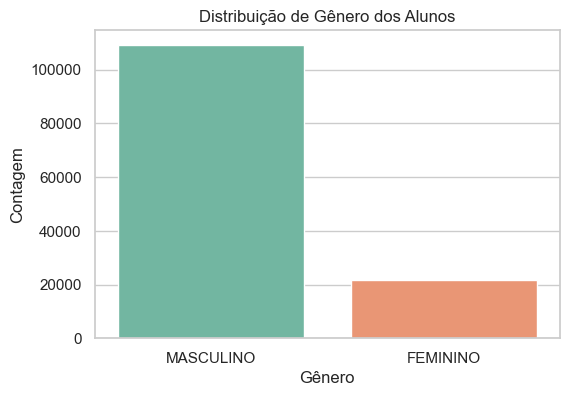

In [39]:
# Contagem de g√™neros
plt.figure(figsize=(6, 4))
sns.countplot(x='GENERO', data=dados_relevantes, palette='Set2')
plt.title('Distribui√ß√£o de G√™nero dos Alunos')
plt.xlabel('G√™nero')
plt.ylabel('Contagem')
plt.show()

### Distribui√ß√£o de Pol√≠tica Afirmativa

C:\Users\Big Data\AppData\Local\Temp\ipykernel_18484\312246021.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='POLITICA_AFIRMATIVA', data=dados_relevantes, palette='Set3')


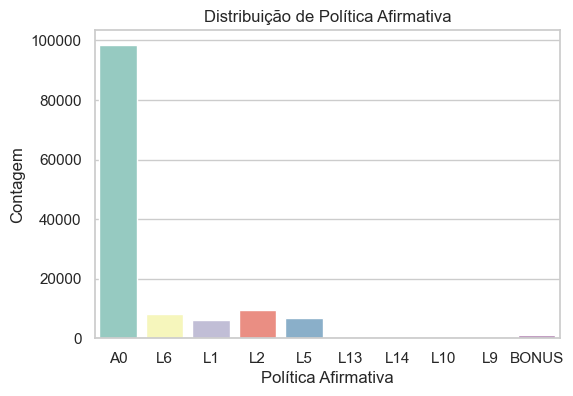

In [40]:
# Contagem de pol√≠tica afirmativa
plt.figure(figsize=(6, 4))
sns.countplot(x='POLITICA_AFIRMATIVA', data=dados_relevantes, palette='Set3')
plt.title('Distribui√ß√£o de Pol√≠tica Afirmativa')
plt.xlabel('Pol√≠tica Afirmativa')
plt.ylabel('Contagem')
plt.show()

### Distribui√ß√£o de Tipo de Ensino M√©dio

C:\Users\Big Data\AppData\Local\Temp\ipykernel_18484\3324000433.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='TIPO_ENSINO_MEDIO', data=dados_relevantes, palette='Set1')


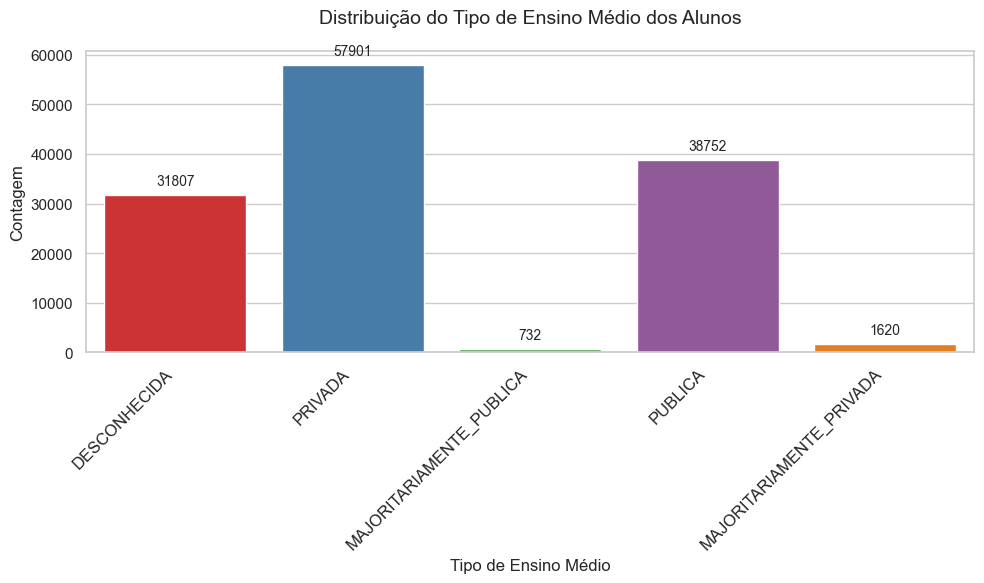

In [41]:
# Contagem de tipo de ensino m√©dio
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='TIPO_ENSINO_MEDIO', data=dados_relevantes, palette='Set1')

# Adicionando contagens em cima das barras
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',  # Valor da contagem
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Posi√ß√£o do texto
        ha='center',  # Alinhamento horizontal
        va='center',  # Alinhamento vertical
        xytext=(0, 10),  # Deslocamento do texto
        textcoords='offset points',  # Tipo de coordenadas
        fontsize=10  # Tamanho da fonte
    )

# Melhorando os r√≥tulos do eixo x
plt.xticks(rotation=45, ha='right', fontsize=12)  # Inclina os r√≥tulos e ajusta o alinhamento

# Melhorando o t√≠tulo e os r√≥tulos dos eixos
plt.title('Distribui√ß√£o do Tipo de Ensino M√©dio dos Alunos', fontsize=14, pad=20)
plt.xlabel('Tipo de Ensino M√©dio', fontsize=12)
plt.ylabel('Contagem', fontsize=12)

# Ajustando o layout para evitar cortes
plt.tight_layout()

# Exibindo o gr√°fico
plt.show()

### Ano de Formatura no Ensino M√©dio e Nota 

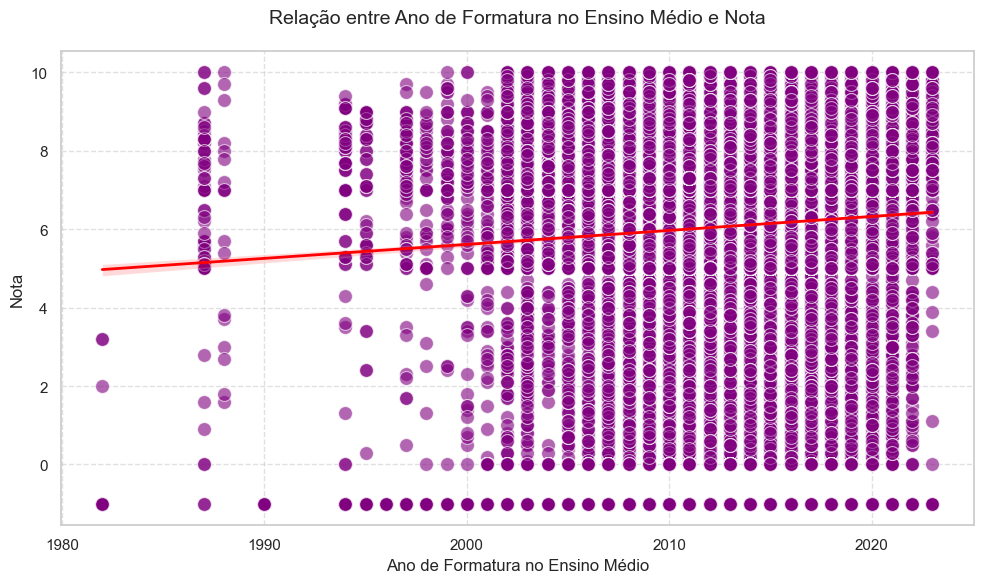

In [42]:
# Gr√°fico de dispers√£o: Ano de Formatura vs Nota
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='ANO_FORMATURA_ENSINO_MEDIO', 
    y='NOTA', 
    data=dados_relevantes, 
    alpha=0.6, 
    color='purple', 
    s=100  # Ajusta o tamanho dos pontos
)

# Adicionando uma linha de tend√™ncia
sns.regplot(
    x='ANO_FORMATURA_ENSINO_MEDIO', 
    y='NOTA', 
    data=dados_relevantes, 
    scatter=False, 
    color='red', 
    line_kws={'linewidth': 2}
)

# Melhorando o t√≠tulo e os r√≥tulos dos eixos
plt.title('Rela√ß√£o entre Ano de Formatura no Ensino M√©dio e Nota', fontsize=14, pad=20)
plt.xlabel('Ano de Formatura no Ensino M√©dio', fontsize=12)
plt.ylabel('Nota', fontsize=12)

# Adicionando uma grade
plt.grid(True, linestyle='--', alpha=0.6)

# Ajustando o layout
plt.tight_layout()

# Exibindo o gr√°fico
plt.show()

C:\Users\Big Data\AppData\Local\Temp\ipykernel_18484\3011583016.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESTATUS', y='NOTA', data=dados_relevantes, palette='Set2')


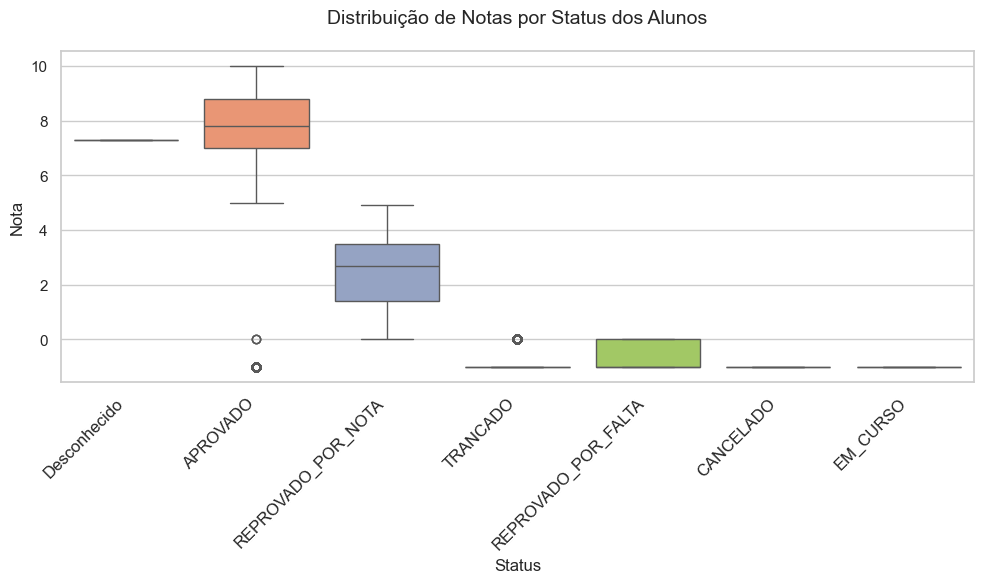

In [43]:
# Boxplot: Nota vs Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='ESTATUS', y='NOTA', data=dados_relevantes, palette='Set2')

# Melhorando os r√≥tulos do eixo x
plt.xticks(rotation=45, ha='right', fontsize=12)  # Inclina os r√≥tulos e ajusta o alinhamento

# Melhorando o t√≠tulo e os r√≥tulos dos eixos
plt.title('Distribui√ß√£o de Notas por Status dos Alunos', fontsize=14, pad=20)
plt.xlabel('Status', fontsize=12)
plt.ylabel('Nota', fontsize=12)

# Ajustando o layout para evitar cortes
plt.tight_layout()

# Exibindo o gr√°fico
plt.show()

### Gr√°fico de Barras Agrupadas: Status vs Ano de Formatura

<Figure size 1400x800 with 0 Axes>

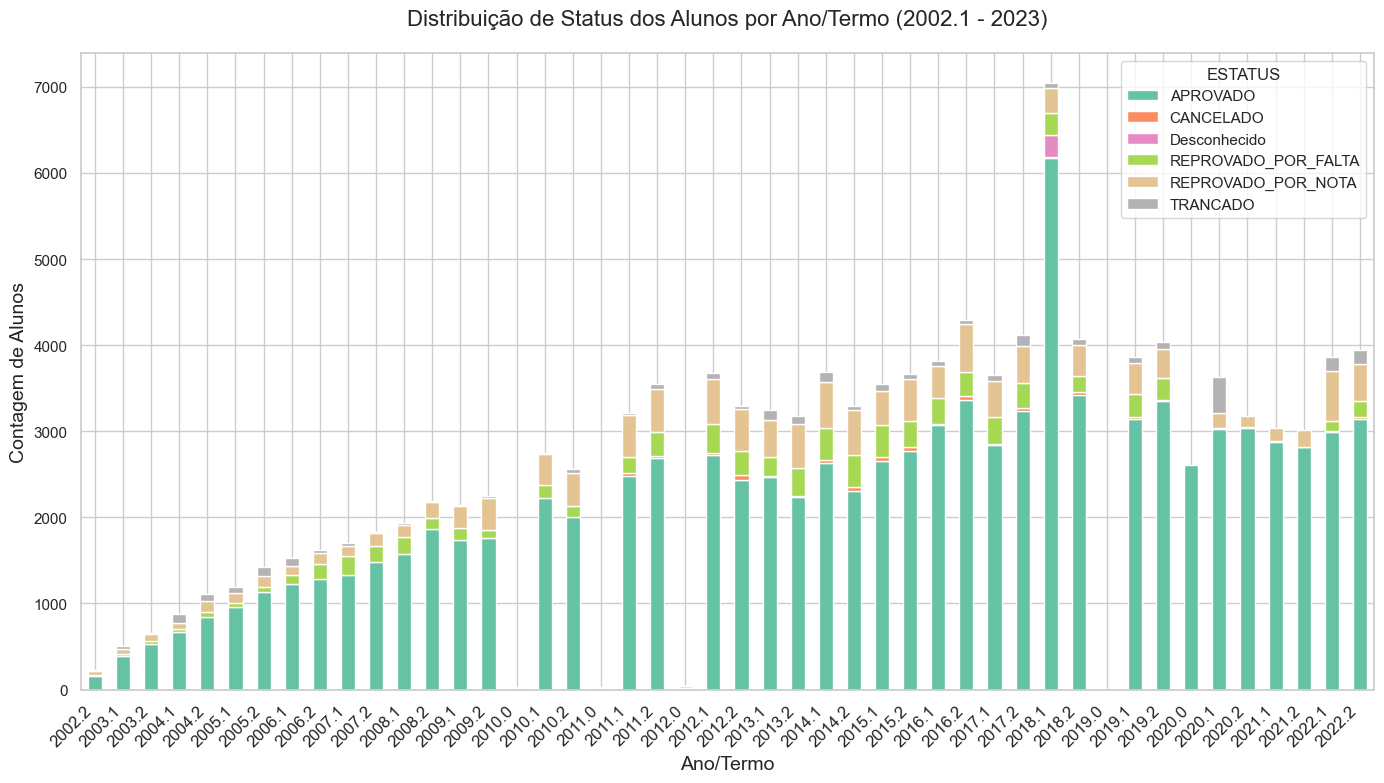

In [44]:
# Criando uma coluna combinando ANO e TERMO (se necess√°rio)
dados_relevantes['ANO_TERMO'] = dados_relevantes['TERMO'].astype(str)

# Filtrando os dados para o per√≠odo desejado (2002.1 a 2023)
dados_filtrados = dados_relevantes[
    (dados_relevantes['TERMO'] >= 2002.1) & (dados_relevantes['TERMO'] <= 2023)
]

# Agrupando os dados por ANO_TERMO e STATUS
dados_agrupados = dados_filtrados.groupby(['ANO_TERMO', 'ESTATUS']).size().unstack()

# Plotando o gr√°fico de barras agrupadas
plt.figure(figsize=(14, 8))
dados_agrupados.plot(kind='bar', stacked=True, colormap='Set2', figsize=(14, 8))

# Melhorando o t√≠tulo e os r√≥tulos dos eixos
plt.title('Distribui√ß√£o de Status dos Alunos por Ano/Termo (2002.1 - 2023)', fontsize=16, pad=20)
plt.xlabel('Ano/Termo', fontsize=14)
plt.ylabel('Contagem de Alunos', fontsize=14)

# Ajustando os r√≥tulos do eixo x
plt.xticks(rotation=45, ha='right', fontsize=12)

# Ajustando o layout
plt.tight_layout()

# Exibindo o gr√°fico
plt.show()

### Gr√°fico de Linhas

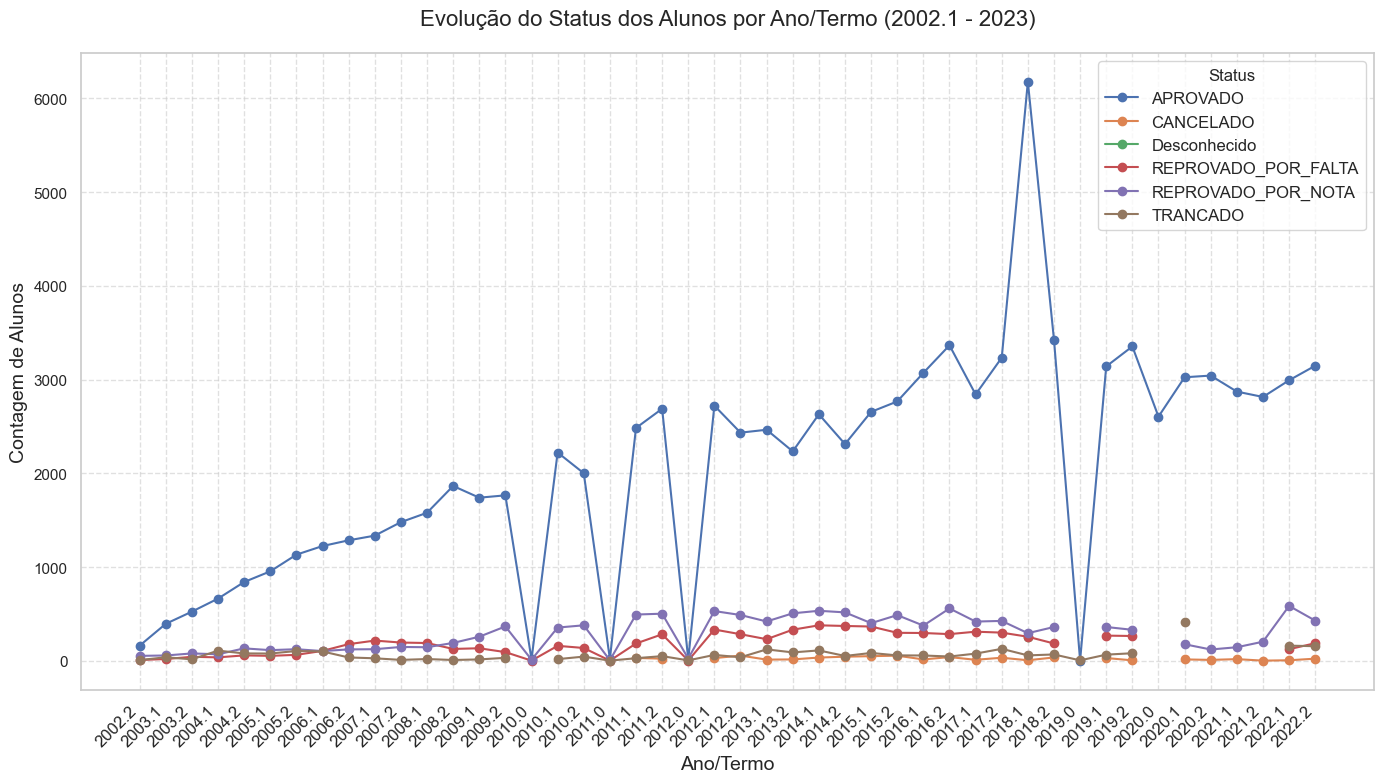

In [45]:
# Plotando o gr√°fico de linhas
plt.figure(figsize=(14, 8))
for status in dados_agrupados.columns:
    plt.plot(dados_agrupados.index, dados_agrupados[status], marker='o', label=status)

# Melhorando o t√≠tulo e os r√≥tulos dos eixos
plt.title('Evolu√ß√£o do Status dos Alunos por Ano/Termo (2002.1 - 2023)', fontsize=16, pad=20)
plt.xlabel('Ano/Termo', fontsize=14)
plt.ylabel('Contagem de Alunos', fontsize=14)

# Ajustando os r√≥tulos do eixo x
plt.xticks(rotation=45, ha='right', fontsize=12)

# Adicionando uma legenda
plt.legend(title='Status', fontsize=12)

# Adicionando uma grade
plt.grid(True, linestyle='--', alpha=0.6)

# Ajustando o layout
plt.tight_layout()

# Exibindo o gr√°fico
plt.show()

### Verificar o N√∫mero de Linhas

In [46]:
# Verificando o n√∫mero de linhas e colunas
num_linhas, num_colunas = dados_relevantes.shape
print(f"A base de dados tem {num_linhas} linhas e {num_colunas} colunas.")

A base de dados tem 130812 linhas e 15 colunas.


### N√∫meros de alunos

In [47]:
num_alunos = dados_relevantes.shape[0]
print(f"N√∫mero total de alunos: {num_alunos}")


N√∫mero total de alunos: 130812


In [48]:
num_alunos_unicos = dados_relevantes['MATRICULA'].nunique()
print(f"N√∫mero de alunos √∫nicos: {num_alunos_unicos}")


N√∫mero de alunos √∫nicos: 3761


### Mostrar Valores √önicos das Vari√°veis Categ√≥ricas

In [49]:
# Listando as colunas categ√≥ricas
colunas_categoricas = dados_relevantes.select_dtypes(include=['object']).columns

# Exibindo os valores √∫nicos de cada vari√°vel categ√≥rica
for coluna in colunas_categoricas:
    valores_unicos = dados_relevantes[coluna].unique()
    print(f"Valores √∫nicos da coluna '{coluna}':")
    print(valores_unicos)
    print("-" * 50)

Valores √∫nicos da coluna 'GENERO':
['MASCULINO' 'FEMININO']
--------------------------------------------------
Valores √∫nicos da coluna 'ESTADO_CIVIL_ALUNOS':
['SOLTEIRO' 'CASADO' 'DESCONHECIDO' 'DIVORCIADO' 'VIUVO']
--------------------------------------------------
Valores √∫nicos da coluna 'NACIONALIDADE':
['BRASILEIRA' 'ESTRANGEIRA' 'BRASILEIRA_POR_NATURALIZACAO']
--------------------------------------------------
Valores √∫nicos da coluna 'ESTADO':
['INATIVO' 'GRADUADO' 'ATIVO']
--------------------------------------------------
Valores √∫nicos da coluna 'RAZAO_INATIVIDADE':
['CANCELAMENTO' 'DESCONHECIDO' 'REINGRESSO' 'ABANDONO' 'EXPULSAO'
 'TRANSFERENCIA' 'OUTROS' 'CONCLUIU_MAS_NAO_COLOU_GRAU' 'DESISTENCIA']
--------------------------------------------------
Valores √∫nicos da coluna 'TIPO_ADMISSAO':
['VESTIBULAR' 'TRANSFERENCIA' 'DECISAO_JUDICIAL_ADM' 'REOPCAO'
 'REINGRESSO' 'CONVENIO' 'SISU' 'GRADUADO']
--------------------------------------------------
Valores √∫nicos da col

Para criar a vari√°vel EVASAO, devemos considerar apenas os alunos que evadiram (ou seja, est√£o INATIVO ou CANCELADO) e os que n√£o evadiram (est√£o ATIVO). Os alunos que j√° se formaram (GRADUADO) devem ser desconsiderados da an√°lise, pois eles conclu√≠ram o curso com sucesso e n√£o se encaixam na defini√ß√£o de evas√£o.

Filtrar os dados:
Remover as linhas onde o ESTADO √© GRADUADO, pois esses alunos n√£o s√£o relevantes para a an√°lise de evas√£o.
Criar a vari√°vel EVASAO:
Atribuir 1 para alunos que evadiram (INATIVO ou CANCELADO).
Atribuir 0 para alunos que n√£o evadiram (ATIVO).

### Criar a Vari√°vel EVASAO

In [50]:
# Filtrando os dados: removendo alunos GRADUADOS
dados_filtrados = dados_relevantes[dados_relevantes['ESTADO'] != 'GRADUADO']

# Criando a vari√°vel EVASAO
dados_filtrados['EVASAO'] = dados_filtrados['ESTADO'].apply(
    lambda x: 1 if x in ['INATIVO', 'CANCELADO'] else 0
)

# Verificando a distribui√ß√£o da vari√°vel EVASAO
print("Distribui√ß√£o da vari√°vel EVASAO:")
print(dados_filtrados['EVASAO'].value_counts())

# Exibindo as primeiras linhas do DataFrame filtrado
print("\nPrimeiras linhas do DataFrame filtrado:")
print(dados_filtrados.head())

Distribui√ß√£o da vari√°vel EVASAO:
EVASAO
1    41348
0    23633
Name: count, dtype: int64

Primeiras linhas do DataFrame filtrado:
    MATRICULA  IDADE     GENERO ESTADO_CIVIL_ALUNOS NACIONALIDADE   ESTADO  \
0   102210001     42  MASCULINO            SOLTEIRO    BRASILEIRA  INATIVO   
91  102210003     40  MASCULINO            SOLTEIRO    BRASILEIRA  INATIVO   
92  102210003     40  MASCULINO            SOLTEIRO    BRASILEIRA  INATIVO   
93  102210003     40  MASCULINO            SOLTEIRO    BRASILEIRA  INATIVO   
94  102210003     40  MASCULINO            SOLTEIRO    BRASILEIRA  INATIVO   

   RAZAO_INATIVIDADE TIPO_ADMISSAO POLITICA_AFIRMATIVA TIPO_ENSINO_MEDIO  \
0       CANCELAMENTO    VESTIBULAR                  A0      DESCONHECIDA   
91        REINGRESSO    VESTIBULAR                  A0      DESCONHECIDA   
92        REINGRESSO    VESTIBULAR                  A0      DESCONHECIDA   
93        REINGRESSO    VESTIBULAR                  A0      DESCONHECIDA   
94        REINGRESS

A distribui√ß√£o da vari√°vel EVASAO mostra que h√° 41.348 alunos que evadiram (valor 1) e 23.633 alunos que n√£o evadiram (valor 0). Isso indica que, na base de dados atual, h√° uma propor√ß√£o maior de evas√£o em rela√ß√£o aos alunos que permanecem ativos. Essa informa√ß√£o √© crucial para a an√°lise, pois j√° nos d√° uma ideia do cen√°rio de evas√£o no curso.

No entanto, √© importante destacar que ainda n√£o aplicamos nenhum modelo de Machine Learning. Neste momento, apenas criamos a vari√°vel EVASAO com base na coluna ESTADO, onde:

1 representa alunos que evadiram (est√£o INATIVO ou CANCELADO).
0 representa alunos que n√£o evadiram (est√£o ATIVO).

Os alunos GRADUADOS foram desconsiderados da an√°lise, pois eles conclu√≠ram o curso com sucesso e n√£o se enquadram na defini√ß√£o de evas√£o.


###  Gr√°fico de Pizza

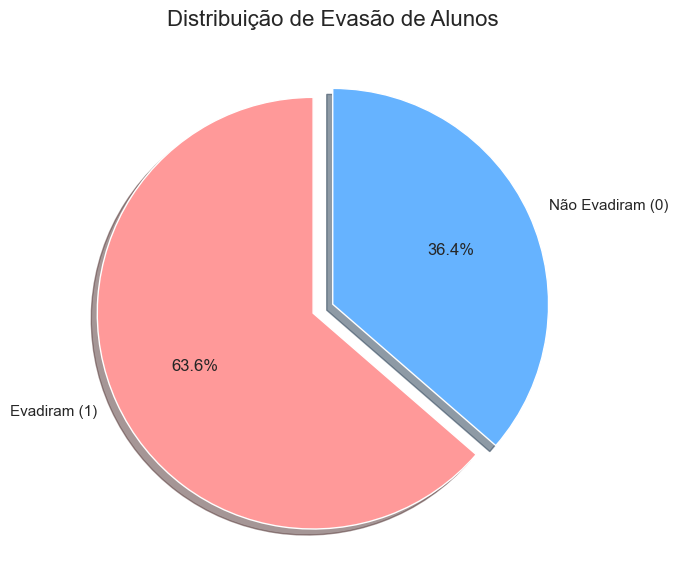

In [51]:
import matplotlib.pyplot as plt

# Contagem de valores da vari√°vel EVASAO
contagem_evasao = dados_filtrados['EVASAO'].value_counts()

# R√≥tulos para o gr√°fico
labels = ['Evadiram (1)', 'N√£o Evadiram (0)']

# Valores para o gr√°fico
sizes = contagem_evasao.values

# Cores para cada fatia
colors = ['#ff9999', '#66b3ff']

# Explodir a fatia "Evadiram" para destac√°-la
explode = (0.1, 0)

# Criando o gr√°fico de pizza
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, shadow=True)

# Adicionando t√≠tulo
plt.title('Distribui√ß√£o de Evas√£o de Alunos', fontsize=16)

# Ajustando o layout
plt.tight_layout()

# Exibindo o gr√°fico
plt.show()

A distribui√ß√£o da vari√°vel EVASAO mostra que h√° 41.348 alunos que evadiram (valor 1) e 23.633 alunos que n√£o evadiram (valor 0). Isso indica que, na base de dados atual, 63,6% dos alunos evadiram, enquanto 36,4% permaneceram ativos. Essa propor√ß√£o revela um cen√°rio significativo de evas√£o no curso, destacando a import√¢ncia de entender os fatores que contribuem para esse fen√¥meno.

√â importante ressaltar que, antes de criar a vari√°vel EVASAO, os alunos GRADUADOS foram removidos da an√°lise, pois eles conclu√≠ram o curso com sucesso e, portanto, n√£o se enquadram na defini√ß√£o de evas√£o. A vari√°vel EVASAO foi constru√≠da com base na coluna ESTADO, onde:

1 representa alunos que evadiram (est√£o INATIVO ou CANCELADO).

0 representa alunos que n√£o evadiram (est√£o ATIVO).

Essa etapa √© preliminar e ainda n√£o aplicamos nenhum modelo de Machine Learning. O objetivo, por enquanto, foi preparar os dados e criar a vari√°vel alvo (EVASAO) para futuras an√°lises e modelagem. A pr√≥xima etapa envolver√° o balanceamento dos dados, a codifica√ß√£o das vari√°veis categ√≥ricas e a aplica√ß√£o de algoritmos de classifica√ß√£o para prever a evas√£o.

### Verificar o Intervalo de Anos

In [52]:
# Extraindo o ano da coluna ANO_TERMO
dados_relevantes['ANO'] = dados_relevantes['ANO_TERMO'].apply(lambda x: int(str(x).split('.')[0]))

# Verificando o ano m√≠nimo e m√°ximo
ano_inicio = dados_relevantes['ANO'].min()
ano_fim = dados_relevantes['ANO'].max()

print(f"O intervalo de anos na base √© de {ano_inicio} a {ano_fim}.")

O intervalo de anos na base √© de 2002 a 2024.


### Codificar Vari√°veis Categ√≥ricas

Agora que j√° criamos a vari√°vel EVASAO, o pr√≥ximo passo √© codificar as vari√°veis categ√≥ricas para preparar os dados para modelos de Machine Learning. Vamos usar duas t√©cnicas principais:

One-Hot Encoding: Para vari√°veis categ√≥ricas nominais (ex: G√äNERO, NACIONALIDADE).
Label Encoding: Para vari√°veis categ√≥ricas ordinais (ex: ESTADO_CIVIL_ALUNOS, TIPO_ENSINO_MEDIO).

In [53]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# 1. One-Hot Encoding para vari√°veis nominais
colunas_one_hot = ['GENERO', 'NACIONALIDADE', 'TIPO_ADMISSAO', 'POLITICA_AFIRMATIVA']
dados_codificados = pd.get_dummies(dados_filtrados, columns=colunas_one_hot, drop_first=True)

# 2. Label Encoding para vari√°veis ordinais
colunas_label_encode = ['ESTADO_CIVIL_ALUNOS', 'TIPO_ENSINO_MEDIO', 'RAZAO_INATIVIDADE', 'ESTATUS']
label_encoder = LabelEncoder()
for coluna in colunas_label_encode:
    dados_codificados[coluna] = label_encoder.fit_transform(dados_filtrados[coluna])

# 3. Exibindo as primeiras linhas do DataFrame codificado
print("Primeiras linhas do DataFrame codificado:")
print(dados_codificados.head())

# 4. Verificando as colunas ap√≥s a codifica√ß√£o
print("\nColunas ap√≥s a codifica√ß√£o:")
print(dados_codificados.columns)

Primeiras linhas do DataFrame codificado:
    MATRICULA  IDADE  ESTADO_CIVIL_ALUNOS   ESTADO  RAZAO_INATIVIDADE  \
0   102210001     42                    3  INATIVO                  1   
91  102210003     40                    3  INATIVO                  7   
92  102210003     40                    3  INATIVO                  7   
93  102210003     40                    3  INATIVO                  7   
94  102210003     40                    3  INATIVO                  7   

    TIPO_ENSINO_MEDIO  ANO_FORMATURA_ENSINO_MEDIO  NOTA  ESTATUS   TERMO  ...  \
0                   0                      2011.0   7.3        2  2018.1  ...   
91                  0                      2011.0  -1.0        6  2002.2  ...   
92                  0                      2011.0   2.0        5  2002.2  ...   
93                  0                      2011.0  -1.0        6  2002.2  ...   
94                  0                      2011.0   7.4        0  2002.2  ...   

   TIPO_ADMISSAO_VESTIBULAR  POL

As vari√°veis categ√≥ricas foram transformadas em formatos num√©ricos, permitindo que algoritmos de Machine Learning processem os dados.
O uso de One-Hot Encoding para vari√°veis nominais evitou a cria√ß√£o de hierarquias artificiais.
O uso de Label Encoding para vari√°veis ordinais preservou a ordem natural das categorias.
A coluna EVASAO (nossa vari√°vel alvo) permaneceu intacta, pronta para ser usada no treinamento do modelo.

### Balanceamento de Dados:

 Balanceamento de Dados. A vari√°vel EVASAO est√° desbalanceada, com 63,6% dos alunos evadidos e 36,4% n√£o evadidos. Para garantir que o modelo de Machine Learning n√£o seja tendencioso em favor da classe majorit√°ria (evadidos), precisamos balancear os dados. Vamos usar a t√©cnica de undersampling, que reduz o n√∫mero de amostras da classe majorit√°ria para igualar √† classe minorit√°ria.

O balanceamento √© aplicado ao conjunto completo de dados, incluindo todas as vari√°veis independentes (features) e a vari√°vel alvo (EVASAO).
O objetivo √© garantir que a propor√ß√£o entre as classes da vari√°vel alvo (EVASAO) seja equilibrada.
Ap√≥s o balanceamento, todas as vari√°veis independentes e a vari√°vel alvo s√£o mantidas no DataFrame balanceado.

In [54]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# 1. Balanceamento dos dados
classe_maioritaria = dados_codificados[dados_codificados['EVASAO'] == 1]
classe_minoritaria = dados_codificados[dados_codificados['EVASAO'] == 0]

classe_maioritaria_undersampled = resample(
    classe_maioritaria,
    replace=False,
    n_samples=len(classe_minoritaria),
    random_state=42
)

dados_balanceados = pd.concat([classe_maioritaria_undersampled, classe_minoritaria])

###  Divis√£o dos Dados em Treino e Teste

In [55]:
# 2. Divis√£o dos dados em treino e teste
X = dados_balanceados.drop(columns=['EVASAO'])  # Todas as colunas, exceto EVASAO
y = dados_balanceados['EVASAO']  # Apenas a coluna EVASAO

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

### Verificando os tamanhos

In [56]:
# Verificando os tamanhos
print(f"Tamanho do conjunto de treino: {len(X_train)} amostras")
print(f"Tamanho do conjunto de teste: {len(X_test)} amostras")

Tamanho do conjunto de treino: 37812 amostras
Tamanho do conjunto de teste: 9454 amostras


Essa divis√£o garante que:
80% dos dados ser√£o usados para treinar o modelo.
20% dos dados ser√£o usados para avaliar o modelo em dados n√£o vistos durante o treinamento.

### Treinamento dos Modelos
Vamos treinar tr√™s modelos:

Regress√£o Log√≠stica: Um modelo simples e interpret√°vel.
Random Forest: Um modelo baseado em √°rvores de decis√£o, robusto e com boa performance.
XGBoost: Um modelo avan√ßado baseado em boosting, conhecido por sua alta precis√£o.

### Instala√ß√£o das Bibliotecas Necess√°rias

In [57]:
pip install scikit-learn xgboost mlflow joblib


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
# Verificando colunas categ√≥ricas n√£o codificadas
colunas_nao_numericas = dados_balanceados.select_dtypes(include=['object']).columns
print("Colunas categ√≥ricas n√£o codificadas:")
print(colunas_nao_numericas)

Colunas categ√≥ricas n√£o codificadas:
Index(['ESTADO', 'ANO_TERMO'], dtype='object')


In [59]:
# Removendo a coluna ESTADO
dados_codificados = dados_balanceados.drop(columns=['ESTADO'])

In [60]:
# Tratar ANO_TERMO
# Extraindo o ano e o semestre da coluna ANO_TERMO
dados_codificados['ANO'] = dados_codificados['ANO_TERMO'].apply(lambda x: int(str(x).split('.')[0]))
dados_codificados['SEMESTRE'] = dados_codificados['ANO_TERMO'].apply(lambda x: int(str(x).split('.')[1]))

# Removendo a coluna ANO_TERMO original
dados_codificados = dados_codificados.drop(columns=['ANO_TERMO'])

In [61]:
# Verificando as primeiras linhas do DataFrame ap√≥s o tratamento
print("Primeiras linhas do DataFrame ap√≥s o tratamento de ANO_TERMO:")
print(dados_codificados[['ANO', 'SEMESTRE']].head())

Primeiras linhas do DataFrame ap√≥s o tratamento de ANO_TERMO:
        ANO  SEMESTRE
97726  2023         1
71901  2020         1
67908  2016         1
34141  2012         2
40463  2011         2


In [62]:
# Verificando as colunas do DataFrame
print("Colunas dispon√≠veis no DataFrame:")
print(dados_codificados.columns)

Colunas dispon√≠veis no DataFrame:
Index(['MATRICULA', 'IDADE', 'ESTADO_CIVIL_ALUNOS', 'RAZAO_INATIVIDADE',
       'TIPO_ENSINO_MEDIO', 'ANO_FORMATURA_ENSINO_MEDIO', 'NOTA', 'ESTATUS',
       'TERMO', 'EVASAO', 'GENERO_MASCULINO',
       'NACIONALIDADE_BRASILEIRA_POR_NATURALIZACAO',
       'NACIONALIDADE_ESTRANGEIRA', 'TIPO_ADMISSAO_DECISAO_JUDICIAL_ADM',
       'TIPO_ADMISSAO_GRADUADO', 'TIPO_ADMISSAO_REOPCAO', 'TIPO_ADMISSAO_SISU',
       'TIPO_ADMISSAO_TRANSFERENCIA', 'TIPO_ADMISSAO_VESTIBULAR',
       'POLITICA_AFIRMATIVA_BONUS', 'POLITICA_AFIRMATIVA_L1',
       'POLITICA_AFIRMATIVA_L10', 'POLITICA_AFIRMATIVA_L13',
       'POLITICA_AFIRMATIVA_L14', 'POLITICA_AFIRMATIVA_L2',
       'POLITICA_AFIRMATIVA_L5', 'POLITICA_AFIRMATIVA_L6',
       'POLITICA_AFIRMATIVA_L9', 'ANO', 'SEMESTRE'],
      dtype='object')


In [63]:
# Verificando os tipos de dados das colunas
print("Tipos de dados das colunas:")
print(dados_codificados.dtypes)

Tipos de dados das colunas:
MATRICULA                                       int64
IDADE                                           int64
ESTADO_CIVIL_ALUNOS                             int64
RAZAO_INATIVIDADE                               int64
TIPO_ENSINO_MEDIO                               int64
ANO_FORMATURA_ENSINO_MEDIO                    float64
NOTA                                          float64
ESTATUS                                         int64
TERMO                                         float64
EVASAO                                          int64
GENERO_MASCULINO                                 bool
NACIONALIDADE_BRASILEIRA_POR_NATURALIZACAO       bool
NACIONALIDADE_ESTRANGEIRA                        bool
TIPO_ADMISSAO_DECISAO_JUDICIAL_ADM               bool
TIPO_ADMISSAO_GRADUADO                           bool
TIPO_ADMISSAO_REOPCAO                            bool
TIPO_ADMISSAO_SISU                               bool
TIPO_ADMISSAO_TRANSFERENCIA                      bool


### Corrigir os Tipos de Dados
Convertendo Colunas Booleanas para Inteiras

In [64]:
# Convertendo colunas booleanas para inteiras
colunas_bool = dados_codificados.select_dtypes(include=['bool']).columns
dados_codificados[colunas_bool] = dados_codificados[colunas_bool].astype(int)

# Verificando os tipos de dados ap√≥s a convers√£o
print("\nTipos de dados ap√≥s convers√£o de booleanos para inteiros:")
print(dados_codificados.dtypes)


Tipos de dados ap√≥s convers√£o de booleanos para inteiros:
MATRICULA                                       int64
IDADE                                           int64
ESTADO_CIVIL_ALUNOS                             int64
RAZAO_INATIVIDADE                               int64
TIPO_ENSINO_MEDIO                               int64
ANO_FORMATURA_ENSINO_MEDIO                    float64
NOTA                                          float64
ESTATUS                                         int64
TERMO                                         float64
EVASAO                                          int64
GENERO_MASCULINO                                int64
NACIONALIDADE_BRASILEIRA_POR_NATURALIZACAO      int64
NACIONALIDADE_ESTRANGEIRA                       int64
TIPO_ADMISSAO_DECISAO_JUDICIAL_ADM              int64
TIPO_ADMISSAO_GRADUADO                          int64
TIPO_ADMISSAO_REOPCAO                           int64
TIPO_ADMISSAO_SISU                              int64
TIPO_ADMISSAO_TRANSFE

Verificando Colunas Categ√≥ricas Restantes

In [65]:
# Verificando colunas categ√≥ricas n√£o codificadas
colunas_nao_numericas = dados_codificados.select_dtypes(include=['object']).columns
print("\nColunas categ√≥ricas n√£o codificadas:")
print(colunas_nao_numericas)


Colunas categ√≥ricas n√£o codificadas:
Index([], dtype='object')


In [66]:
# Visualizando as primeiras linhas do DataFrame
print(dados_codificados.head())

# Verificando as colunas dispon√≠veis
print(dados_codificados.columns)

# Verificando algumas estat√≠sticas descritivas
print(dados_codificados.describe())

# Verificando a distribui√ß√£o da vari√°vel alvo 'EVASAO'
print(dados_codificados['EVASAO'].value_counts())

       MATRICULA  IDADE  ESTADO_CIVIL_ALUNOS  RAZAO_INATIVIDADE  \
97726  118110711     24                    3                  5   
71901  115210432     29                    3                  2   
67908  115110811     28                    3                  5   
34141  110210386     33                    3                  7   
40463  111210434     31                    0                  0   

       TIPO_ENSINO_MEDIO  ANO_FORMATURA_ENSINO_MEDIO  NOTA  ESTATUS   TERMO  \
97726                  4                      2017.0   0.0        5  2023.1   
71901                  4                      2014.0   7.8        0  2020.1   
67908                  4                      2014.0   7.2        0  2016.1   
34141                  3                      2009.0   1.7        5  2012.2   
40463                  2                      2010.0   6.5        0  2011.2   

       EVASAO  ...  POLITICA_AFIRMATIVA_L1  POLITICA_AFIRMATIVA_L10  \
97726       1  ...                       1         

### Divis√£o dos Dados

In [67]:
from sklearn.model_selection import train_test_split

# Definindo as vari√°veis independentes (X) e a vari√°vel dependente (y)
X = dados_codificados.drop(columns=['EVASAO'])  # Todas as colunas, exceto a vari√°vel alvo
y = dados_codificados['EVASAO']  # Apenas a coluna EVASAO

# Dividindo os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% dos dados para teste
    random_state=42  # Semente para reprodutibilidade
)

# Verificando o tamanho dos conjuntos
print(f"Tamanho do conjunto de treino: {len(X_train)} amostras")
print(f"Tamanho do conjunto de teste: {len(X_test)} amostras")

Tamanho do conjunto de treino: 37812 amostras
Tamanho do conjunto de teste: 9454 amostras


### Regress√£o Log√≠stica

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Criando e treinando o modelo de Regress√£o Log√≠stica
modelo_rl = LogisticRegression(max_iter=1000)
modelo_rl.fit(X_train, y_train)

# Fazendo previs√µes
y_pred_rl = modelo_rl.predict(X_test)

# Avalia√ß√£o do modelo
acuracia_rl = accuracy_score(y_test, y_pred_rl)
precisao_rl = precision_score(y_test, y_pred_rl, average='weighted')
recall_rl = recall_score(y_test, y_pred_rl, average='weighted')
f1_rl = f1_score(y_test, y_pred_rl, average='weighted')

print("\nüîπ Regress√£o Log√≠stica:")
print(f"Acur√°cia: {acuracia_rl:.4f}")
print(f"Precis√£o: {precisao_rl:.4f}")
print(f"Recall: {recall_rl:.4f}")
print(f"F1-Score: {f1_rl:.4f}")



üîπ Regress√£o Log√≠stica:
Acur√°cia: 0.8702
Precis√£o: 0.8760
Recall: 0.8702
F1-Score: 0.8696


### Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier

# Criando e treinando o modelo Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

# Fazendo previs√µes
y_pred_rf = modelo_rf.predict(X_test)

# Avalia√ß√£o do modelo
acuracia_rf = accuracy_score(y_test, y_pred_rf)
precisao_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print("\nüîπ Random Forest:")
print(f"Acur√°cia: {acuracia_rf:.4f}")
print(f"Precis√£o: {precisao_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")



üîπ Random Forest:
Acur√°cia: 0.9999
Precis√£o: 0.9999
Recall: 0.9999
F1-Score: 0.9999


###  XGBoost

In [70]:
from xgboost import XGBClassifier

# Criando e treinando o modelo XGBoost
modelo_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
modelo_xgb.fit(X_train, y_train)

# Fazendo previs√µes
y_pred_xgb = modelo_xgb.predict(X_test)

# Avalia√ß√£o do modelo
acuracia_xgb = accuracy_score(y_test, y_pred_xgb)
precisao_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

print("\nüîπ XGBoost:")
print(f"Acur√°cia: {acuracia_xgb:.4f}")
print(f"Precis√£o: {precisao_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-Score: {f1_xgb:.4f}")


C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



üîπ XGBoost:
Acur√°cia: 1.0000
Precis√£o: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [71]:
from sklearn.neighbors import KNeighborsClassifier

# Criando e treinando o modelo KNN
modelo_knn = KNeighborsClassifier(n_neighbors=5)  # N√∫mero de vizinhos = 5 (pode ajustar conforme necess√°rio)
modelo_knn.fit(X_train, y_train)

# Fazendo previs√µes
y_pred_knn = modelo_knn.predict(X_test)

# Avalia√ß√£o do modelo
acuracia_knn = accuracy_score(y_test, y_pred_knn)
precisao_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

print("\nüîπ KNN:")
print(f"Acur√°cia: {acuracia_knn:.4f}")
print(f"Precis√£o: {precisao_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1-Score: {f1_knn:.4f}")



üîπ KNN:
Acur√°cia: 0.9801
Precis√£o: 0.9802
Recall: 0.9801
F1-Score: 0.9801


In [72]:
from sklearn.ensemble import AdaBoostClassifier

# Criando e treinando o modelo AdaBoost
modelo_ada = AdaBoostClassifier(n_estimators=50, random_state=42)  # 50 estimadores (pode ajustar)
modelo_ada.fit(X_train, y_train)

# Fazendo previs√µes
y_pred_ada = modelo_ada.predict(X_test)

# Avalia√ß√£o do modelo
acuracia_ada = accuracy_score(y_test, y_pred_ada)
precisao_ada = precision_score(y_test, y_pred_ada, average='weighted')
recall_ada = recall_score(y_test, y_pred_ada, average='weighted')
f1_ada = f1_score(y_test, y_pred_ada, average='weighted')

print("\nüîπ AdaBoost:")
print(f"Acur√°cia: {acuracia_ada:.4f}")
print(f"Precis√£o: {precisao_ada:.4f}")
print(f"Recall: {recall_ada:.4f}")
print(f"F1-Score: {f1_ada:.4f}")



üîπ AdaBoost:
Acur√°cia: 1.0000
Precis√£o: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [73]:
from sklearn.svm import SVC

# Criando e treinando o modelo SVC
modelo_svc = SVC(kernel='rbf', probability=True, random_state=42)  # Kernel RBF (padr√£o)
modelo_svc.fit(X_train, y_train)

# Fazendo previs√µes
y_pred_svc = modelo_svc.predict(X_test)

# Avalia√ß√£o do modelo
acuracia_svc = accuracy_score(y_test, y_pred_svc)
precisao_svc = precision_score(y_test, y_pred_svc, average='weighted')
recall_svc = recall_score(y_test, y_pred_svc, average='weighted')
f1_svc = f1_score(y_test, y_pred_svc, average='weighted')

print("\nüîπ SVC (Support Vector Classifier):")
print(f"Acur√°cia: {acuracia_svc:.4f}")
print(f"Precis√£o: {precisao_svc:.4f}")
print(f"Recall: {recall_svc:.4f}")
print(f"F1-Score: {f1_svc:.4f}")



üîπ SVC (Support Vector Classifier):
Acur√°cia: 0.8737
Precis√£o: 0.8808
Recall: 0.8737
F1-Score: 0.8730


1. Overfitting (Superajuste)
O modelo pode ter memorizado os dados de treino em vez de aprender padr√µes reais. Isso √© comum em modelos como Random Forest, XGBoost e AdaBoost, que s√£o muito expressivos e podem se ajustar perfeitamente ao conjunto de treino.
Se o conjunto de teste for pequeno ou muito semelhante ao de treino, o modelo pode simplesmente memorizar as respostas corretas.


### Trabalho relacionado Allan

### Modelo Global vs Modelo Espec√≠fico

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Definindo as vari√°veis independentes (X) e a vari√°vel dependente (y)
X = dados_codificados.drop(columns=['EVASAO'])  # Todas as colunas, exceto a vari√°vel alvo
y = dados_codificados['EVASAO']  # Apenas a coluna EVASAO

# Dividindo os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Criando Modelo Global (todos os dados)
modelo_global = RandomForestClassifier(random_state=42)
modelo_global.fit(X_train, y_train)

# Criando Modelo Espec√≠fico (apenas alunos de escola p√∫blica)
X_train_especifico = X_train[X_train['TIPO_ENSINO_MEDIO'] == 1]
y_train_especifico = y_train.loc[X_train_especifico.index]  # Filtrar y correspondente

modelo_especifico = RandomForestClassifier(random_state=42)
modelo_especifico.fit(X_train_especifico, y_train_especifico)

# Avalia√ß√£o do Modelo Global
y_pred_global = modelo_global.predict(X_test)
print("Resultados do Modelo Global:")
print(classification_report(y_test, y_pred_global))

# Avalia√ß√£o do Modelo Espec√≠fico (aplicado apenas no subconjunto do teste)
X_test_especifico = X_test[X_test['TIPO_ENSINO_MEDIO'] == 1]
y_test_especifico = y_test.loc[X_test_especifico.index]
y_pred_especifico = modelo_especifico.predict(X_test_especifico)

print("\nResultados do Modelo Espec√≠fico:")
print(classification_report(y_test_especifico, y_pred_especifico))


Resultados do Modelo Global:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4772
           1       1.00      1.00      1.00      4682

    accuracy                           1.00      9454
   macro avg       1.00      1.00      1.00      9454
weighted avg       1.00      1.00      1.00      9454


Resultados do Modelo Espec√≠fico:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        80

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98



In [76]:
print("Colunas dispon√≠veis:", dados_codificados.columns)


Colunas dispon√≠veis: Index(['MATRICULA', 'IDADE', 'ESTADO_CIVIL_ALUNOS', 'RAZAO_INATIVIDADE',
       'TIPO_ENSINO_MEDIO', 'ANO_FORMATURA_ENSINO_MEDIO', 'NOTA', 'ESTATUS',
       'TERMO', 'EVASAO', 'GENERO_MASCULINO',
       'NACIONALIDADE_BRASILEIRA_POR_NATURALIZACAO',
       'NACIONALIDADE_ESTRANGEIRA', 'TIPO_ADMISSAO_DECISAO_JUDICIAL_ADM',
       'TIPO_ADMISSAO_GRADUADO', 'TIPO_ADMISSAO_REOPCAO', 'TIPO_ADMISSAO_SISU',
       'TIPO_ADMISSAO_TRANSFERENCIA', 'TIPO_ADMISSAO_VESTIBULAR',
       'POLITICA_AFIRMATIVA_BONUS', 'POLITICA_AFIRMATIVA_L1',
       'POLITICA_AFIRMATIVA_L10', 'POLITICA_AFIRMATIVA_L13',
       'POLITICA_AFIRMATIVA_L14', 'POLITICA_AFIRMATIVA_L2',
       'POLITICA_AFIRMATIVA_L5', 'POLITICA_AFIRMATIVA_L6',
       'POLITICA_AFIRMATIVA_L9', 'ANO', 'SEMESTRE'],
      dtype='object')


### Inicializar o DVC no Reposit√≥rio

In [77]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configurar o diret√≥rio de logs novamente (para garantir)
mlflow.set_tracking_uri(f"file:///{caminho_logs}")

# Definir o nome do experimento
mlflow.set_experiment("Evasao_UFCG")

# Definir as vari√°veis independentes (X) e a vari√°vel alvo (y)
X = dados_codificados.drop(columns=['EVASAO'])  # Removendo a vari√°vel-alvo dos preditores
y = dados_codificados['EVASAO']  # Apenas a vari√°vel de sa√≠da (1 = Evadiu, 0 = N√£o evadiu)

# Dividindo os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% dos dados para teste
    random_state=42,  # Para garantir reprodutibilidade
    stratify=y  # Garante que a propor√ß√£o de evas√£o se mantenha nos conjuntos
)

# Criar modelos
modelos = {
    "Regress√£o Log√≠stica": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Treinar e avaliar modelos
resultados = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")
    
    # Iniciar o MLflow para cada modelo
    with mlflow.start_run():
        # Registrar par√¢metros do modelo (exemplo: hiperpar√¢metros)
        mlflow.log_param("modelo", nome)
        
        # Treinando o modelo
        modelo.fit(X_train, y_train)  
        y_pred = modelo.predict(X_test)  # Fazendo previs√µes

        # Calculando m√©tricas de avalia√ß√£o
        acuracia = accuracy_score(y_test, y_pred)
        precisao = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')

        # Armazenando os resultados
        resultados[nome] = {
            "Acur√°cia": acuracia,
            "Precis√£o": precisao,
            "Recall": recall,
            "F1-Score": f1
        }

        # Registrar m√©tricas no MLflow
        mlflow.log_metric("Acur√°cia", acuracia)
        mlflow.log_metric("Precis√£o", precisao)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1-Score", f1)
        
        print(f"{nome} - Acur√°cia: {acuracia:.4f}, Precis√£o: {precisao:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Exibir os resultados finais
print("\nResultados dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")


Treinando Regress√£o Log√≠stica...
Regress√£o Log√≠stica - Acur√°cia: 0.8736, Precis√£o: 0.9274, Recall: 0.8107, F1-Score: 0.8651

Treinando Random Forest...
Random Forest - Acur√°cia: 0.9999, Precis√£o: 1.0000, Recall: 0.9998, F1-Score: 0.9999

Treinando XGBoost...


C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:04:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Acur√°cia: 1.0000, Precis√£o: 1.0000, Recall: 1.0000, F1-Score: 1.0000

Resultados dos Modelos:

Regress√£o Log√≠stica:
Acur√°cia: 0.8736
Precis√£o: 0.9274
Recall: 0.8107
F1-Score: 0.8651

Random Forest:
Acur√°cia: 0.9999
Precis√£o: 1.0000
Recall: 0.9998
F1-Score: 0.9999

XGBoost:
Acur√°cia: 1.0000
Precis√£o: 1.0000
Recall: 1.0000
F1-Score: 1.0000


###  MLflow para Salvar os Experimentes

In [78]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

### Processo de registro no MLflow para monitoramento de m√©tricas e execu√ß√£o.

In [79]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definir o URI de rastreamento do MLflow
mlflow.set_tracking_uri("file:///E:/Mestrado UFCG/Semestre 2024.2/Dados/MLOps dropout/Experimentos_MLflow/mlruns")

# Definir o nome do experimento
mlflow.set_experiment("Treinamento_Modelos")

# Definir as vari√°veis independentes (X) e a vari√°vel alvo (y)
X = dados_codificados.drop(columns=['EVASAO'])  # Removendo a vari√°vel-alvo dos preditores
y = dados_codificados['EVASAO']  # Apenas a vari√°vel de sa√≠da (1 = Evadiu, 0 = N√£o evadiu)

# Dividindo os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% dos dados para teste
    random_state=42,  # Para garantir reprodutibilidade
    stratify=y  # Garante que a propor√ß√£o de evas√£o se mantenha nos conjuntos
)

# Criar modelos
modelos = {
    "Regress√£o Log√≠stica": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Treinar e registrar modelos no MLflow
resultados = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")
    
    # Iniciar um experimento no MLflow
    with mlflow.start_run():
        mlflow.log_param("Modelo", nome)  # Registrar o nome do modelo
        
        # Treinando o modelo
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)  # Fazendo previs√µes
        
        # Calculando m√©tricas de avalia√ß√£o
        acuracia = accuracy_score(y_test, y_pred)
        precisao = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')

        # Registrar m√©tricas no MLflow
        mlflow.log_metric("Acur√°cia", acuracia)
        mlflow.log_metric("Precis√£o", precisao)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1-Score", f1)
        
        # Salvar o modelo no MLflow
        if nome == "XGBoost":
            mlflow.xgboost.log_model(modelo, "model")
        else:
            mlflow.sklearn.log_model(modelo, "model")
        
        # Armazenando os resultados
        resultados[nome] = {
            "Acur√°cia": acuracia,
            "Precis√£o": precisao,
            "Recall": recall,
            "F1-Score": f1
        }
        
        print(f"{nome} - Acur√°cia: {acuracia:.4f}, Precis√£o: {precisao:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Exibir os resultados finais
print("\nResultados dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")


2025/04/25 14:04:40 INFO mlflow.tracking.fluent: Experiment with name 'Treinamento_Modelos' does not exist. Creating a new experiment.



Treinando Regress√£o Log√≠stica...


2025/04/25 14:04:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Regress√£o Log√≠stica - Acur√°cia: 0.8736, Precis√£o: 0.9274, Recall: 0.8107, F1-Score: 0.8651

Treinando Random Forest...


2025/04/25 14:05:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest - Acur√°cia: 0.9999, Precis√£o: 1.0000, Recall: 0.9998, F1-Score: 0.9999

Treinando XGBoost...


C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:05:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:05:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/04/25 14:05:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost - Acur√°cia: 1.0000, Precis√£o: 1.0000, Recall: 1.0000, F1-Score: 1.0000

Resultados dos Modelos:

Regress√£o Log√≠stica:
Acur√°cia: 0.8736
Precis√£o: 0.9274
Recall: 0.8107
F1-Score: 0.8651

Random Forest:
Acur√°cia: 0.9999
Precis√£o: 1.0000
Recall: 0.9998
F1-Score: 0.9999

XGBoost:
Acur√°cia: 1.0000
Precis√£o: 1.0000
Recall: 1.0000
F1-Score: 1.0000


###  Visualizar no MLflow

In [80]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definir a URL de rastreamento do MLflow (diret√≥rio dos experimentos)
mlflow.set_tracking_uri("file:///E:/Mestrado UFCG/Semestre 2024.2/Dados/MLOps dropout/Experimentos_MLflow")

# Definir o nome do experimento
mlflow.set_experiment("Treinamento_Modelos")

# Definir as vari√°veis independentes (X) e a vari√°vel alvo (y)
X = dados_codificados.drop(columns=['EVASAO'])  # Removendo a vari√°vel-alvo dos preditores
y = dados_codificados['EVASAO']  # Apenas a vari√°vel de sa√≠da (1 = Evadiu, 0 = N√£o evadiu)

# Dividindo os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% dos dados para teste
    random_state=42,  # Para garantir reprodutibilidade
    stratify=y  # Garante que a propor√ß√£o de evas√£o se mantenha nos conjuntos
)

# Criar modelos
modelos = {
    "Regress√£o Log√≠stica": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Treinar e registrar modelos no MLflow
resultados = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")
    
    # Iniciar um experimento no MLflow
    with mlflow.start_run():
        mlflow.log_param("Modelo", nome)  # Registrar o nome do modelo
        
        # Treinando o modelo
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)  # Fazendo previs√µes
        
        # Calculando m√©tricas de avalia√ß√£o
        acuracia = accuracy_score(y_test, y_pred)
        precisao = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')

        # Registrar m√©tricas no MLflow
        mlflow.log_metric("Acur√°cia", acuracia)
        mlflow.log_metric("Precis√£o", precisao)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1-Score", f1)
        
        # Salvar o modelo no MLflow
        if nome == "XGBoost":
            mlflow.xgboost.log_model(modelo, "model")
            print(f"Modelo {nome} salvo no MLflow.")
        else:
            mlflow.sklearn.log_model(modelo, "model")
            print(f"Modelo {nome} salvo no MLflow.")
        
        # Armazenando os resultados
        resultados[nome] = {
            "Acur√°cia": acuracia,
            "Precis√£o": precisao,
            "Recall": recall,
            "F1-Score": f1
        }
        
        print(f"{nome} - Acur√°cia: {acuracia:.4f}, Precis√£o: {precisao:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Exibir os resultados finais
print("\nResultados dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")


Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.


Treinando Regress√£o Log√≠stica...


2025/04/25 14:05:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo Regress√£o Log√≠stica salvo no MLflow.
Regress√£o Log√≠stica - Acur√°cia: 0.8736, Precis√£o: 0.9274, Recall: 0.8107, F1-Score: 0.8651

Treinando Random Forest...


2025/04/25 14:05:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo Random Forest salvo no MLflow.
Random Forest - Acur√°cia: 0.9999, Precis√£o: 1.0000, Recall: 0.9998, F1-Score: 0.9999

Treinando XGBoost...


C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:05:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:05:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/04/25 14:05:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo XGBoost salvo no MLflow.
XGBoost - Acur√°cia: 1.0000, Precis√£o: 1.0000, Recall: 1.0000, F1-Score: 1.0000

Resultados dos Modelos:

Regress√£o Log√≠stica:
Acur√°cia: 0.8736
Precis√£o: 0.9274
Recall: 0.8107
F1-Score: 0.8651

Random Forest:
Acur√°cia: 0.9999
Precis√£o: 1.0000
Recall: 0.9998
F1-Score: 0.9999

XGBoost:
Acur√°cia: 1.0000
Precis√£o: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [81]:
import mlflow

# Listar todos os experimentos
experimentos = mlflow.search_experiments()
for exp in experimentos:
    print(f"ID: {exp.experiment_id}, Nome: {exp.name}")

Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.

ID: 606799937749384898, Nome: Treinamento_Modelos
ID: 280216387810933266, Nome: Carregamento de Dados UFCG
ID: 973689039483717455, Nome: Evasao_UFCG


In [82]:
import mlflow

# Listar execu√ß√µes do experimento
experimento = mlflow.get_experiment_by_name("Treinamento_Modelos")
if experimento:
    execucoes = mlflow.search_runs(experimento.experiment_id)
    print(execucoes)
else:
    print("Experimento n√£o encontrado.")

Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.

                             run_id       experiment_id    status  \
0  cc97903b3d1a44d3aaaadc582ea2c554  606799937749384898  FINISHED   
1  99b0106fa996454999eb96b4f2031854  606799937749384898  FINISHED   
2  c4e5f23963bf4fa3a97a4fe8cae5fd20  606799937749384898  FINISHED   

                                        artifact_uri  \
0  file:///E:/Mestrado UFCG/Semestre 2024.2/Dados...   
1  file:///E:/Mestrado UFCG/Semestre 2024.2/Dados...   
2  file:///E:/Mestrado UFCG/Semestre 2024.2/Dados...   

                        start_time                         end_time  \
0 2025-04-25 17:05:27.940000+00:00 2025-04-25 17:05:35.570000+00:00   
1 2025-04-25 17:05:18.639000+00:00 2025-04-25 17:05:27.932000+00:00   
2 2025-04-25 17:05:11.576000+00:00 2025-04-25 17:05:18.629000+00:00   

   metrics.F1-Score  metrics.Acur√°cia  metrics.Precis√£o  metrics.Recall  \
0          1.000000          1.000000          1.000000        1.000000   
1          0.999894          0.999894          1.000000      

In [83]:
import mlflow

# Listar todos os experimentos
experimentos = mlflow.search_experiments()
for exp in experimentos:
    print(f"ID: {exp.experiment_id}, Nome: {exp.name}")

Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.

ID: 606799937749384898, Nome: Treinamento_Modelos
ID: 280216387810933266, Nome: Carregamento de Dados UFCG
ID: 973689039483717455, Nome: Evasao_UFCG


In [84]:
import mlflow

# Listar execu√ß√µes do experimento
experimento = mlflow.get_experiment_by_name("Treinamento_Modelos")
if experimento:
    execucoes = mlflow.search_runs(experimento.experiment_id)
    print(execucoes)
else:
    print("Experimento n√£o encontrado.")

Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.

                             run_id       experiment_id    status  \
0  cc97903b3d1a44d3aaaadc582ea2c554  606799937749384898  FINISHED   
1  99b0106fa996454999eb96b4f2031854  606799937749384898  FINISHED   
2  c4e5f23963bf4fa3a97a4fe8cae5fd20  606799937749384898  FINISHED   

                                        artifact_uri  \
0  file:///E:/Mestrado UFCG/Semestre 2024.2/Dados...   
1  file:///E:/Mestrado UFCG/Semestre 2024.2/Dados...   
2  file:///E:/Mestrado UFCG/Semestre 2024.2/Dados...   

                        start_time                         end_time  \
0 2025-04-25 17:05:27.940000+00:00 2025-04-25 17:05:35.570000+00:00   
1 2025-04-25 17:05:18.639000+00:00 2025-04-25 17:05:27.932000+00:00   
2 2025-04-25 17:05:11.576000+00:00 2025-04-25 17:05:18.629000+00:00   

   metrics.F1-Score  metrics.Acur√°cia  metrics.Precis√£o  metrics.Recall  \
0          1.000000          1.000000          1.000000        1.000000   
1          0.999894          0.999894          1.000000      

In [85]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
experimentos = client.search_experiments()  # Lista todos os experimentos
for exp in experimentos:
    print(f"ID: {exp.experiment_id}, Nome: {exp.name}")


Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.

ID: 606799937749384898, Nome: Treinamento_Modelos
ID: 280216387810933266, Nome: Carregamento de Dados UFCG
ID: 973689039483717455, Nome: Evasao_UFCG


In [86]:
import mlflow
print(mlflow.get_tracking_uri())


file:///E:/Mestrado UFCG/Semestre 2024.2/Dados/MLOps dropout/Experimentos_MLflow


In [89]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configura√ß√£o do MLflow
mlflow.set_tracking_uri("http://localhost:5000")  # Defina o tracking server
mlflow.set_experiment("Predi√ß√£o de Evas√£o - UFCG")  # Nome do experimento

# Definir as vari√°veis independentes (X) e a vari√°vel alvo (y)
X = dados_codificados.drop(columns=['EVASAO'])  # Removendo a vari√°vel-alvo dos preditores
y = dados_codificados['EVASAO']  # Apenas a vari√°vel de sa√≠da (1 = Evadiu, 0 = N√£o evadiu)

# Dividindo os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% dos dados para teste
    random_state=42,  # Para garantir reprodutibilidade
    stratify=y  # Garante que a propor√ß√£o de evas√£o se mantenha nos conjuntos
)

# Criar modelos
modelos = {
    "Regress√£o Log√≠stica": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Treinar e registrar modelos no MLflow
resultados = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")

    with mlflow.start_run(run_name=nome):  # Criar um "run" no MLflow
        mlflow.log_param("Modelo", nome)  # Registrar o nome do modelo

        # Treinando o modelo
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)  # Fazendo previs√µes
        
        # Calculando m√©tricas de avalia√ß√£o
        acuracia = accuracy_score(y_test, y_pred)
        precisao = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')

        # Registrar m√©tricas no MLflow
        mlflow.log_metric("Acur√°cia", acuracia)
        mlflow.log_metric("Precis√£o", precisao)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1-Score", f1)
        
        # Salvar o modelo treinado no MLflow
        if nome == "XGBoost":
            mlflow.xgboost.log_model(modelo, f"modelos/{nome}")
        else:
            mlflow.sklearn.log_model(modelo, f"modelos/{nome}")
        
        # Armazenando os resultados
        resultados[nome] = {
            "Acur√°cia": acuracia,
            "Precis√£o": precisao,
            "Recall": recall,
            "F1-Score": f1
        }

        print(f"{nome} - Acur√°cia: {acuracia:.4f}, Precis√£o: {precisao:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Exibir os resultados finais
print("\nResultados dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")



Treinando Regress√£o Log√≠stica...


2025/04/25 14:27:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Regress√£o Log√≠stica - Acur√°cia: 0.8736, Precis√£o: 0.9274, Recall: 0.8107, F1-Score: 0.8651
üèÉ View run Regress√£o Log√≠stica at: http://localhost:5000/#/experiments/746483729393550037/runs/82bc89f9f71a4a74bf1b1c69e85df14e
üß™ View experiment at: http://localhost:5000/#/experiments/746483729393550037

Treinando Random Forest...


2025/04/25 14:27:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest - Acur√°cia: 0.9999, Precis√£o: 1.0000, Recall: 0.9998, F1-Score: 0.9999
üèÉ View run Random Forest at: http://localhost:5000/#/experiments/746483729393550037/runs/9a4c092e36544889b1c85292b6f05301
üß™ View experiment at: http://localhost:5000/#/experiments/746483729393550037

Treinando XGBoost...


C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:27:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:27:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/04/25 14:27:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost - Acur√°cia: 1.0000, Precis√£o: 1.0000, Recall: 1.0000, F1-Score: 1.0000
üèÉ View run XGBoost at: http://localhost:5000/#/experiments/746483729393550037/runs/82b6337a856e4ba8a01f3a274c7da2e6
üß™ View experiment at: http://localhost:5000/#/experiments/746483729393550037

Resultados dos Modelos:

Regress√£o Log√≠stica:
Acur√°cia: 0.8736
Precis√£o: 0.9274
Recall: 0.8107
F1-Score: 0.8651

Random Forest:
Acur√°cia: 0.9999
Precis√£o: 1.0000
Recall: 0.9998
F1-Score: 0.9999

XGBoost:
Acur√°cia: 1.0000
Precis√£o: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [91]:
import matplotlib.pyplot as plt
import numpy as np
import mlflow

# Criar gr√°ficos para cada modelo
for nome, modelo in modelos.items():
    # Fazer previs√µes no conjunto de teste
    y_pred = modelo.predict(X_test)
    
    # Contar quantos alunos foram realmente previstos como evadidos e n√£o evadidos
    evadidos = sum(y_pred == 1)
    nao_evadidos = sum(y_pred == 0)

    plt.figure(figsize=(6, 4))
    plt.bar(["N√£o Evadiram", "Evadiram"], [nao_evadidos, evadidos], color=['blue', 'red'])

    # Adicionar r√≥tulos num√©ricos dentro das barras
    plt.text(0, nao_evadidos + 1, str(nao_evadidos), ha='center', fontsize=12, fontweight='bold')
    plt.text(1, evadidos + 1, str(evadidos), ha='center', fontsize=12, fontweight='bold')

    plt.xlabel("Situa√ß√£o do Aluno")
    plt.ylabel("N√∫mero de Alunos")
    plt.title(f"Previs√£o de Evas√£o - {nome}")
    plt.ylim(0, max(nao_evadidos, evadidos) + 5)  # Ajusta a escala do gr√°fico

    # Salvar gr√°fico no MLflow
    grafico_path = f"grafico_{nome.replace(' ', '_')}.png"
    plt.savefig(grafico_path)
    plt.close()

    # Registrar o gr√°fico no MLflow
    with mlflow.start_run():
        mlflow.log_artifact(grafico_path)


üèÉ View run entertaining-owl-391 at: http://localhost:5000/#/experiments/746483729393550037/runs/f3043618816d4a15b39d4bb128e65dce
üß™ View experiment at: http://localhost:5000/#/experiments/746483729393550037
üèÉ View run adorable-grouse-875 at: http://localhost:5000/#/experiments/746483729393550037/runs/911a4cd6e4f6445f9ee0ed8dbcb61e6d
üß™ View experiment at: http://localhost:5000/#/experiments/746483729393550037
üèÉ View run illustrious-gnat-513 at: http://localhost:5000/#/experiments/746483729393550037/runs/eb3b3da8a1294da68f7f4755b9af0d3d
üß™ View experiment at: http://localhost:5000/#/experiments/746483729393550037


### Incluir os modelos KNN, SVC e AdaBoost no MLflow:

In [93]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definir a URI de rastreamento do MLflow (experimentos salvos em diret√≥rio local)
mlflow.set_tracking_uri("file:///E:/Mestrado UFCG/Semestre 2024.2/Dados/MLOps dropout/Experimentos_MLflow")
mlflow.set_experiment("Treinamento_Modelos")

# Separa√ß√£o das vari√°veis preditoras e alvo
X = dados_codificados.drop(columns=['EVASAO'])
y = dados_codificados['EVASAO']

# Divis√£o treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Dicion√°rio com os modelos a treinar
modelos = {
    "Regress√£o Log√≠stica": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf', probability=True),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

# Resultados finais
resultados = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")

    with mlflow.start_run(run_name=nome):
        mlflow.set_tag("tipo_modelo", nome)
        mlflow.log_param("Modelo", nome)

        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # M√©tricas
        acuracia = accuracy_score(y_test, y_pred)
        precisao = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')

        mlflow.log_metrics({
            "Acur√°cia": acuracia,
            "Precis√£o": precisao,
            "Recall": recall,
            "F1-Score": f1
        })

        # Log do modelo
        if nome == "XGBoost":
            mlflow.xgboost.log_model(modelo, "model")
        else:
            mlflow.sklearn.log_model(modelo, "model")

        print(f"Modelo {nome} salvo no MLflow.")
        
        resultados[nome] = {
            "Acur√°cia": acuracia,
            "Precis√£o": precisao,
            "Recall": recall,
            "F1-Score": f1
        }

# Impress√£o dos resultados no console
print("\nResultados dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")


Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.


Treinando Regress√£o Log√≠stica...


2025/04/25 14:49:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo Regress√£o Log√≠stica salvo no MLflow.

Treinando Random Forest...


2025/04/25 14:49:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo Random Forest salvo no MLflow.

Treinando XGBoost...


C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:49:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:49:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/04/25 14:49:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo XGBoost salvo no MLflow.

Treinando KNN...


2025/04/25 14:49:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo KNN salvo no MLflow.

Treinando SVC...


2025/04/25 14:57:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo SVC salvo no MLflow.

Treinando AdaBoost...


2025/04/25 14:57:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo AdaBoost salvo no MLflow.

Resultados dos Modelos:

Regress√£o Log√≠stica:
Acur√°cia: 0.8736
Precis√£o: 0.9274
Recall: 0.8107
F1-Score: 0.8651

Random Forest:
Acur√°cia: 0.9999
Precis√£o: 1.0000
Recall: 0.9998
F1-Score: 0.9999

XGBoost:
Acur√°cia: 1.0000
Precis√£o: 1.0000
Recall: 1.0000
F1-Score: 1.0000

KNN:
Acur√°cia: 0.9841
Precis√£o: 0.9891
Recall: 0.9791
F1-Score: 0.9841

SVC:
Acur√°cia: 0.8776
Precis√£o: 0.9386
Recall: 0.8081
F1-Score: 0.8685

AdaBoost:
Acur√°cia: 1.0000
Precis√£o: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [95]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definir a URI de rastreamento do MLflow (experimentos salvos em diret√≥rio local)
mlflow.set_tracking_uri("file:///E:/Mestrado UFCG/Semestre 2024.2/Dados/MLOps dropout/Experimentos_MLflow")
nome_experimento = "Treinamento_Modelos"
mlflow.set_experiment(nome_experimento)

# Pegar o ID do experimento
experiment = mlflow.get_experiment_by_name(nome_experimento)
experiment_id = experiment.experiment_id
base_url = f"http://localhost:5000/#/experiments/{experiment_id}"

# Separa√ß√£o das vari√°veis preditoras e alvo
X = dados_codificados.drop(columns=['EVASAO'])
y = dados_codificados['EVASAO']

# Divis√£o treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Dicion√°rio com os modelos a treinar (XGBoost removido)
modelos = {
    "Regress√£o Log√≠stica": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf', probability=True),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

# Resultados finais
resultados = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")

    with mlflow.start_run(run_name=nome) as run:
        mlflow.set_tag("tipo_modelo", nome)
        mlflow.log_param("Modelo", nome)

        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # M√©tricas
        acuracia = accuracy_score(y_test, y_pred)
        precisao = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')

        mlflow.log_metrics({
            "Acur√°cia": acuracia,
            "Precis√£o": precisao,
            "Recall": recall,
            "F1-Score": f1
        })

        # Log do modelo
        mlflow.sklearn.log_model(modelo, "model")

        print(f"Modelo {nome} salvo no MLflow.")
        
        # Exibir links
        run_id = run.info.run_id
        print(f"üèÉ View run {run.data.tags.get('mlflow.runName')} at: {base_url}/runs/{run_id}")
        print(f"üß™ View experiment at: {base_url}")

        resultados[nome] = {
            "Acur√°cia": acuracia,
            "Precis√£o": precisao,
            "Recall": recall,
            "F1-Score": f1
        }

# Impress√£o dos resultados no console
print("\nResultados dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")


Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.


Treinando Regress√£o Log√≠stica...


2025/04/25 15:09:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo Regress√£o Log√≠stica salvo no MLflow.
üèÉ View run Regress√£o Log√≠stica at: http://localhost:5000/#/experiments/606799937749384898/runs/2c68a60dcb8b4d61bca61b78010588d3
üß™ View experiment at: http://localhost:5000/#/experiments/606799937749384898

Treinando Random Forest...


2025/04/25 15:09:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo Random Forest salvo no MLflow.
üèÉ View run Random Forest at: http://localhost:5000/#/experiments/606799937749384898/runs/db3060d3b7f242beb1de89c54b78fb2b
üß™ View experiment at: http://localhost:5000/#/experiments/606799937749384898

Treinando KNN...


2025/04/25 15:09:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo KNN salvo no MLflow.
üèÉ View run KNN at: http://localhost:5000/#/experiments/606799937749384898/runs/9a535c48add84d6d934bd0bbaa7cb959
üß™ View experiment at: http://localhost:5000/#/experiments/606799937749384898

Treinando SVC...


2025/04/25 15:18:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo SVC salvo no MLflow.
üèÉ View run SVC at: http://localhost:5000/#/experiments/606799937749384898/runs/48b763f3b11841589d05043bc411ec53
üß™ View experiment at: http://localhost:5000/#/experiments/606799937749384898

Treinando AdaBoost...


2025/04/25 15:18:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo AdaBoost salvo no MLflow.
üèÉ View run AdaBoost at: http://localhost:5000/#/experiments/606799937749384898/runs/bb42c675db4644ff9fe67cb48a914007
üß™ View experiment at: http://localhost:5000/#/experiments/606799937749384898

Resultados dos Modelos:

Regress√£o Log√≠stica:
Acur√°cia: 0.8736
Precis√£o: 0.9274
Recall: 0.8107
F1-Score: 0.8651

Random Forest:
Acur√°cia: 0.9999
Precis√£o: 1.0000
Recall: 0.9998
F1-Score: 0.9999

KNN:
Acur√°cia: 0.9841
Precis√£o: 0.9891
Recall: 0.9791
F1-Score: 0.9841

SVC:
Acur√°cia: 0.8776
Precis√£o: 0.9386
Recall: 0.8081
F1-Score: 0.8685

AdaBoost:
Acur√°cia: 1.0000
Precis√£o: 1.0000
Recall: 1.0000
F1-Score: 1.0000


### Treina e avalia cada modelo.
### Loga as m√©tricas e o modelo no MLflow.
### Salva e envia um .csv com as matr√≠culas dos alunos previstos como evasores.
### Imprime os links de execu√ß√£o e experimento, prontos para clicar no terminal.

In [96]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Definir a URL de rastreamento do MLflow
mlflow.set_tracking_uri("file:///E:/Mestrado UFCG/Semestre 2024.2/Dados/MLOps dropout/Experimentos_MLflow")
mlflow.set_experiment("Treinamento_Modelos")

# Separar dados
matriculas = dados_codificados['MATRICULA']
X = dados_codificados.drop(columns=['EVASAO', 'MATRICULA'])
y = dados_codificados['EVASAO']

# Dividir os dados
X_train, X_test, y_train, y_test, matriculas_train, matriculas_test = train_test_split(
    X, y, matriculas,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Modelos
modelos = {
    "Regress√£o Log√≠stica": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf', probability=True),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

resultados = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")

    with mlflow.start_run(run_name=nome) as run:
        mlflow.log_param("Modelo", nome)
        
        # Treinar
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # M√©tricas
        acuracia = accuracy_score(y_test, y_pred)
        precisao = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        mlflow.log_metric("Acur√°cia", acuracia)
        mlflow.log_metric("Precis√£o", precisao)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1-Score", f1)

        # Salvar modelo
        mlflow.sklearn.log_model(modelo, "model")

        # Filtrar matr√≠culas dos alunos previstos como evasores
        evasores_previstos = matriculas_test[y_pred == 1]
        caminho_csv = f"matriculas_evasores_{nome.replace(' ', '_')}.csv"
        evasores_previstos.to_csv(caminho_csv, index=False)
        mlflow.log_artifact(caminho_csv)

        print(f"üèÉ View run {run.data.tags.get('mlflow.runName')} at: http://localhost:5000/#/experiments/{run.info.experiment_id}/runs/{run.info.run_id}")
        print(f"üß™ View experiment at: http://localhost:5000/#/experiments/{run.info.experiment_id}")

        resultados[nome] = {
            "Acur√°cia": acuracia,
            "Precis√£o": precisao,
            "Recall": recall,
            "F1-Score": f1
        }

# Exibir resultados
print("\nResultados dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")


Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.


Treinando Regress√£o Log√≠stica...


C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/04/25 15:20:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run Regress√£o Log√≠stica at: http://localhost:5000/#/experiments/606799937749384898/runs/273e5c21c3ca4d1e81efefa51b435c87
üß™ View experiment at: http://localhost:5000/#/experiments/606799937749384898

Treinando Random Forest...


2025/04/25 15:20:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run Random Forest at: http://localhost:5000/#/experiments/606799937749384898/runs/21738313c64c4c18b55e64417e010723
üß™ View experiment at: http://localhost:5000/#/experiments/606799937749384898

Treinando KNN...


2025/04/25 15:20:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run KNN at: http://localhost:5000/#/experiments/606799937749384898/runs/a9079b67fcff4a9b853997671454cb79
üß™ View experiment at: http://localhost:5000/#/experiments/606799937749384898

Treinando SVC...


2025/04/25 15:41:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run SVC at: http://localhost:5000/#/experiments/606799937749384898/runs/7df7165f4b574426a09d3e3306f3c118
üß™ View experiment at: http://localhost:5000/#/experiments/606799937749384898

Treinando AdaBoost...


2025/04/25 15:41:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run AdaBoost at: http://localhost:5000/#/experiments/606799937749384898/runs/5f59851258144229bc8eec9eb2cdfa3f
üß™ View experiment at: http://localhost:5000/#/experiments/606799937749384898

Resultados dos Modelos:

Regress√£o Log√≠stica:
Acur√°cia: 0.8828
Precis√£o: 0.9104
Recall: 0.8492
F1-Score: 0.8787

Random Forest:
Acur√°cia: 0.9999
Precis√£o: 1.0000
Recall: 0.9998
F1-Score: 0.9999

KNN:
Acur√°cia: 0.9911
Precis√£o: 0.9974
Recall: 0.9848
F1-Score: 0.9911

SVC:
Acur√°cia: 0.7929
Precis√£o: 0.9901
Recall: 0.5917
F1-Score: 0.7407

AdaBoost:
Acur√°cia: 1.0000
Precis√£o: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [103]:
# Filtrar colunas com "MATRICULA" ou que sejam vers√µes codificadas das relevantes
variaveis_convertidas = [col for col in dados_codificados.columns if any(
    chave in col for chave in ['MATRICULA', 'IDADE', 'ESTADO_CIVIL_ALUNOS', 'RAZAO_INATIVIDADE',
                               'TIPO_ENSINO_MEDIO', 'ANO_FORMATURA_ENSINO_MEDIO', 'NOTA', 'ESTATUS',
                               'TERMO', 'GENERO', 'NACIONALIDADE', 'TIPO_ADMISSAO',
                               'POLITICA_AFIRMATIVA']
)]

# Mostrar as primeiras linhas
dados_codificados[variaveis_convertidas].head()


MATRICULA  IDADE  ESTADO_CIVIL_ALUNOS  RAZAO_INATIVIDADE  \
97726  118110711     24                    3                  5   
71901  115210432     29                    3                  2   
67908  115110811     28                    3                  5   
34141  110210386     33                    3                  7   
40463  111210434     31                    0                  0   

       TIPO_ENSINO_MEDIO  ANO_FORMATURA_ENSINO_MEDIO  NOTA  ESTATUS   TERMO  \
97726                  4                      2017.0   0.0        5  2023.1   
71901                  4                      2014.0   7.8        0  2020.1   
67908                  4                      2014.0   7.2        0  2016.1   
34141                  3                      2009.0   1.7        5  2012.2   
40463                  2                      2010.0   6.5        0  2011.2   

       GENERO_MASCULINO  ...  TIPO_ADMISSAO_VESTIBULAR  \
97726                 1  ...                         0   
71901                 0  ...                         0   
67908                 1  ...                         0   
34141                 1  ...                         1   
40463                 1  ...                         1   

       POLITICA_AFIRMATIVA_BONUS  POLITICA_AFIRMATIVA_L1  \
97726                          0                       1   
71901                          0                       0   
67908                          0                       0   
34141                          0                       0   
40463                          0                       0   

       POLITICA_AFIRMATIVA_L10  POLITICA_AFIRMATIVA_L13  \
97726                        0                        0   
71901                        0                        0   
67908                        0                        0   
34141                        0                        0   
40463                        0                        0   

       POLITICA_AFIRMATIVA_L14  POLITICA_AFIRMATIVA_L2  \
97726                        0                       0   
71901                        0                       1   
67908                        0                       0   
34141                        0                       0   
40463                        0                       0   

       POLITICA_AFIRMATIVA_L5  POLITICA_AFIRMATIVA_L6  POLITICA_AFIRMATIVA_L9  
97726                       0                       0                       0  
71901                       0                       0                       0  
67908                       0                       1                       0  
34141                       0                       0                       0  
40463                       0                       0                       0  

[5 rows x 27 columns]

In [106]:
# Filtrar matr√≠culas dos alunos previstos como evasores
evasores_previstos = matriculas_test[y_pred == 1]

# Verificar se existem evasores previstos
print(f"Total de evasores previstos: {len(evasores_previstos)}")
if len(evasores_previstos) == 0:
    print("Nenhum evasor previsto!")
else:
    # Obter as linhas completas dos evasores, incluindo outras vari√°veis relevantes
    evasores_completos = dados_codificados.loc[matriculas_test.index[y_pred == 1], variaveis_convertidas]

    # Verificar as primeiras linhas para garantir que os dados est√£o corretos
    print(f"Primeiras linhas dos evasores com vari√°veis relevantes:\n{evasores_completos.head()}")

    # Adicionar uma coluna 'MATRICULA' para o DataFrame
    evasores_completos['MATRICULA'] = evasores_previstos.values

    # Caminho para salvar o arquivo CSV
    caminho_csv = f"matriculas_evasores_com_variaveis_{nome.replace(' ', '_')}.csv"

    # Salvar o CSV com as matr√≠culas e as vari√°veis relevantes
    evasores_completos.to_csv(caminho_csv, index=False)

    # Logar o arquivo no MLflow
    mlflow.log_artifact(caminho_csv)
    print(f"Arquivo salvo em: {caminho_csv}")


Total de evasores previstos: 4727
Primeiras linhas dos evasores com vari√°veis relevantes:
        MATRICULA  IDADE  ESTADO_CIVIL_ALUNOS  RAZAO_INATIVIDADE  \
105572  119110534     24                    3                  2   
72996   115210797     26                    3                  0   
118160  120210547     27                    3                  5   
70388   115111825     34                    3                  5   
22597   108210207     36                    3                  7   

        TIPO_ENSINO_MEDIO  ANO_FORMATURA_ENSINO_MEDIO  NOTA  ESTATUS   TERMO  \
105572                  4                      2018.0  10.0        0  2021.2   
72996                   1                      2014.0   7.8        0  2016.1   
118160                  4                      2014.0  -1.0        0  2020.2   
70388                   3                      2007.0  -1.0        6  2017.2   
22597                   0                      2011.0   3.6        5  2012.1   

        GENERO_MASC

In [ ]:
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Definir a URL de rastreamento do MLflow
mlflow.set_tracking_uri("file:///E:/Mestrado UFCG/Semestre 2024.2/Dados/MLOps dropout/Experimentos_MLflow")
mlflow.set_experiment("Treinamento_Modelos")

# Separar dados
matriculas = dados_codificados['MATRICULA']
X = dados_codificados.drop(columns=['EVASAO', 'MATRICULA'])
y = dados_codificados['EVASAO']

# Dividir os dados
X_train, X_test, y_train, y_test, matriculas_train, matriculas_test = train_test_split(
    X, y, matriculas,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Modelos
modelos = {
    "Regress√£o Log√≠stica": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf', probability=True),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

resultados = {}

# Garantir que qualquer execu√ß√£o anterior seja finalizada
if mlflow.active_run():
    mlflow.end_run()

# Iniciar e finalizar o run para cada modelo
for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")

    with mlflow.start_run(run_name=nome) as run:
        mlflow.log_param("Modelo", nome)
        
        # Treinar
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # M√©tricas
        acuracia = accuracy_score(y_test, y_pred)
        precisao = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        mlflow.log_metric("Acur√°cia", acuracia)
        mlflow.log_metric("Precis√£o", precisao)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1-Score", f1)

        # Salvar modelo
        mlflow.sklearn.log_model(modelo, "model")

        # Filtrar matr√≠culas dos alunos previstos como evasores
        evasores_previstos = matriculas_test[y_pred == 1]
        caminho_csv = f"matriculas_evasores_{nome.replace(' ', '_')}.csv"
        evasores_previstos.to_csv(caminho_csv, index=False)
        mlflow.log_artifact(caminho_csv)

        print(f"üèÉ View run {run.data.tags.get('mlflow.runName')} at: http://localhost:5000/#/experiments/{run.info.experiment_id}/runs/{run.info.run_id}")
        print(f"üß™ View experiment at: http://localhost:5000/#/experiments/{run.info.experiment_id}")

        resultados[nome] = {
            "Acur√°cia": acuracia,
            "Precis√£o": precisao,
            "Recall": recall,
            "F1-Score": f1
        }

# Exibir resultados
print("\nResultados dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")

# Passo 2: Comparar as matr√≠culas previstas como evasores com a base 'dados_codificados' 
# para selecionar as vari√°veis relevantes

# Carregar o arquivo CSV com as matr√≠culas de evasores
evasores_previstos = pd.read_csv(f"matriculas_evasores_{nome.replace(' ', '_')}.csv")

# Passo 3: Verificar as matr√≠culas previstas nos dados_codificados
evasores_completos = dados_codificados[dados_codificados['MATRICULA'].isin(evasores_previstos['MATRICULA'])]

# Selecionar apenas as vari√°veis relevantes
variaveis_relevantes = [
    'MATRICULA', 'IDADE', 'GENERO', 'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 
    'ESTADO', 'RAZAO_INATIVIDADE', 'TIPO_ADMISSAO', 'POLITICA_AFIRMATIVA', 
    'TIPO_ENSINO_MEDIO', 'ANO_FORMATURA_ENSINO_MEDIO', 'NOTA', 'ESTATUS', 'TERMO'
]

evasores_completos_relevantes = evasores_completos[variaveis_relevantes]

# Exibir as primeiras linhas dos evasores com vari√°veis relevantes
print("Primeiras linhas dos evasores com vari√°veis relevantes:")
print(evasores_completos_relevantes.head())

# Passo 4: Explora√ß√£o gr√°fica (exemplo de gr√°ficos)

# Exemplo de gr√°fico de barras da idade dos evasores
plt.figure(figsize=(10, 6))
sns.histplot(evasores_completos_relevantes['IDADE'], bins=20, kde=True)
plt.title('Distribui√ß√£o de Idade dos Evasores')
plt.xlabel('Idade')
plt.ylabel('Frequ√™ncia')
plt.show()

# Exemplo de gr√°fico de barras para o estado civil dos evasores
plt.figure(figsize=(10, 6))
sns.countplot(data=evasores_completos_relevantes, x='ESTADO_CIVIL_ALUNOS')
plt.title('Distribui√ß√£o de Estado Civil dos Evasores')
plt.xlabel('Estado Civil')
plt.ylabel('Frequ√™ncia')
plt.show()

# Outros gr√°ficos podem ser feitos com base nas vari√°veis selecionadas


Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.


Treinando Regress√£o Log√≠stica...


C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/04/25 17:25:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run Regress√£o Log√≠stica at: http://localhost:5000/#/experiments/606799937749384898/runs/ba5ec3b5308546b1acdb9202cc6593d8
üß™ View experiment at: http://localhost:5000/#/experiments/606799937749384898

Treinando Random Forest...


2025/04/25 17:25:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run Random Forest at: http://localhost:5000/#/experiments/606799937749384898/runs/59740d0e80b04abb80d92fa4f7e10001
üß™ View experiment at: http://localhost:5000/#/experiments/606799937749384898

Treinando KNN...


2025/04/25 17:25:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run KNN at: http://localhost:5000/#/experiments/606799937749384898/runs/09be296f1cbd4fe8a4b40d8ce331267c
üß™ View experiment at: http://localhost:5000/#/experiments/606799937749384898

Treinando SVC...


###  analisar Balanceados em rela√ß√£o √† vari√°vel alvo EVASAO

Distribui√ß√£o das classes:
EVASAO
1    23633
0    23633
Name: count, dtype: int64

Percentual:
EVASAO
1    50.0
0    50.0
Name: proportion, dtype: float64


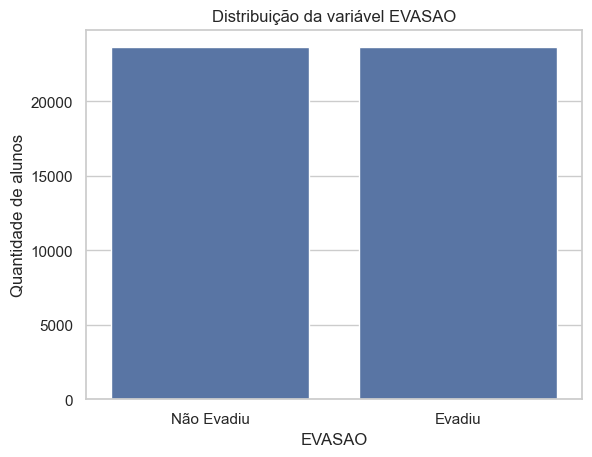

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

# Contagem das classes
contagem = dados_codificados['EVASAO'].value_counts()
percentual = dados_codificados['EVASAO'].value_counts(normalize=True) * 100

print("Distribui√ß√£o das classes:")
print(contagem)
print("\nPercentual:")
print(percentual.round(2))

# Gr√°fico
sns.barplot(x=contagem.index, y=contagem.values)
plt.xticks([0, 1], ['N√£o Evadiu', 'Evadiu'])
plt.ylabel("Quantidade de alunos")
plt.title("Distribui√ß√£o da vari√°vel EVASAO")
plt.show()


### Verificar total da base

In [98]:
print("Total de alunos na base:", len(dados_codificados))


Total de alunos na base: 47266


### Verificar alunos classificados com risco

In [92]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definir a URL de rastreamento do MLflow (diret√≥rio dos experimentos)
mlflow.set_tracking_uri("file:///E:/Mestrado UFCG/Semestre 2024.2/Dados/MLOps dropout/Experimentos_MLflow")

# Definir o nome do experimento
mlflow.set_experiment("Treinamento_Modelos")

# Definir as vari√°veis independentes (X) e a vari√°vel alvo (y)
X = dados_codificados.drop(columns=['EVASAO'])  # Removendo a vari√°vel-alvo dos preditores
y = dados_codificados['EVASAO']  # Apenas a vari√°vel de sa√≠da (1 = Evadiu, 0 = N√£o evadiu)

# Dividindo os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% dos dados para teste
    random_state=42,  # Para garantir reprodutibilidade
    stratify=y  # Garante que a propor√ß√£o de evas√£o se mantenha nos conjuntos
)

# Criar modelos
modelos = {
    "Regress√£o Log√≠stica": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf', probability=True),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

# Treinar e registrar modelos no MLflow
resultados = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")
    
    # Iniciar um experimento no MLflow
    with mlflow.start_run():
        mlflow.log_param("Modelo", nome)  # Registrar o nome do modelo
        
        # Treinando o modelo
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)  # Fazendo previs√µes
        
        # Calculando m√©tricas de avalia√ß√£o
        acuracia = accuracy_score(y_test, y_pred)
        precisao = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')

        # Registrar m√©tricas no MLflow
        mlflow.log_metric("Acur√°cia", acuracia)
        mlflow.log_metric("Precis√£o", precisao)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1-Score", f1)
        
        # Salvar o modelo no MLflow
        if nome == "XGBoost":
            mlflow.xgboost.log_model(modelo, "model")
        else:
            mlflow.sklearn.log_model(modelo, "model")
        
        print(f"Modelo {nome} salvo no MLflow.")
        
        # Armazenando os resultados
        resultados[nome] = {
            "Acur√°cia": acuracia,
            "Precis√£o": precisao,
            "Recall": recall,
            "F1-Score": f1
        }
        
        print(f"{nome} - Acur√°cia: {acuracia:.4f}, Precis√£o: {precisao:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Exibir os resultados finais
print("\nResultados dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")


Traceback (most recent call last):
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.


Treinando Regress√£o Log√≠stica...


2025/04/25 14:31:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo Regress√£o Log√≠stica salvo no MLflow.
Regress√£o Log√≠stica - Acur√°cia: 0.8736, Precis√£o: 0.9274, Recall: 0.8107, F1-Score: 0.8651

Treinando Random Forest...


2025/04/25 14:31:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo Random Forest salvo no MLflow.
Random Forest - Acur√°cia: 0.9999, Precis√£o: 1.0000, Recall: 0.9998, F1-Score: 0.9999

Treinando XGBoost...


C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:31:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Big Data\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:31:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/04/25 14:31:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo XGBoost salvo no MLflow.
XGBoost - Acur√°cia: 1.0000, Precis√£o: 1.0000, Recall: 1.0000, F1-Score: 1.0000

Treinando KNN...


2025/04/25 14:31:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo KNN salvo no MLflow.
KNN - Acur√°cia: 0.9841, Precis√£o: 0.9891, Recall: 0.9791, F1-Score: 0.9841

Treinando SVC...


2025/04/25 14:40:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo SVC salvo no MLflow.
SVC - Acur√°cia: 0.8776, Precis√£o: 0.9386, Recall: 0.8081, F1-Score: 0.8685

Treinando AdaBoost...


2025/04/25 14:40:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo AdaBoost salvo no MLflow.
AdaBoost - Acur√°cia: 1.0000, Precis√£o: 1.0000, Recall: 1.0000, F1-Score: 1.0000

Resultados dos Modelos:

Regress√£o Log√≠stica:
Acur√°cia: 0.8736
Precis√£o: 0.9274
Recall: 0.8107
F1-Score: 0.8651

Random Forest:
Acur√°cia: 0.9999
Precis√£o: 1.0000
Recall: 0.9998
F1-Score: 0.9999

XGBoost:
Acur√°cia: 1.0000
Precis√£o: 1.0000
Recall: 1.0000
F1-Score: 1.0000

KNN:
Acur√°cia: 0.9841
Precis√£o: 0.9891
Recall: 0.9791
F1-Score: 0.9841

SVC:
Acur√°cia: 0.8776
Precis√£o: 0.9386
Recall: 0.8081
F1-Score: 0.8685

AdaBoost:
Acur√°cia: 1.0000
Precis√£o: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [ ]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definir a URI de rastreamento do MLflow (experimentos salvos em diret√≥rio local)
mlflow.set_tracking_uri("file:///E:/Mestrado UFCG/Semestre 2024.2/Dados/MLOps dropout/Experimentos_MLflow")
mlflow.set_experiment("Treinamento_Modelos")

# Separa√ß√£o das vari√°veis preditoras e alvo
X = dados_codificados.drop(columns=['EVASAO'])
y = dados_codificados['EVASAO']

# Divis√£o treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Dicion√°rio com os modelos a treinar
modelos = {
    "Regress√£o Log√≠stica": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf', probability=True),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

# Resultados finais
resultados = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")

    with mlflow.start_run(run_name=nome):
        mlflow.set_tag("tipo_modelo", nome)
        mlflow.log_param("Modelo", nome)

        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # M√©tricas
        acuracia = accuracy_score(y_test, y_pred)
        precisao = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')

        mlflow.log_metrics({
            "Acur√°cia": acuracia,
            "Precis√£o": precisao,
            "Recall": recall,
            "F1-Score": f1
        })

        # Log do modelo
        if nome == "XGBoost":
            mlflow.xgboost.log_model(modelo, "model")
        else:
            mlflow.sklearn.log_model(modelo, "model")

        print(f"Modelo {nome} salvo no MLflow.")
        
        resultados[nome] = {
            "Acur√°cia": acuracia,
            "Precis√£o": precisao,
            "Recall": recall,
            "F1-Score": f1
        }

# Impress√£o dos resultados no console
print("\nResultados dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")


# Modelos que atingem 1.0 em todas as m√©tricas podem estar sofrendo de overfitting ou usando alguma forma de "c√≥pia" dos dados (como vazamento de informa√ß√£o). 

### Experimentos incluindo valida√ß√£o cruzada com 5 folds (cv=5)

In [94]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np  # Para calcular m√©dias das m√©tricas

# Configura√ß√£o do MLflow
mlflow.set_tracking_uri("http://localhost:5000")  # Defina o tracking server
mlflow.set_experiment("Predi√ß√£o de Evas√£o - UFCG")  # Nome do experimento

# Definir as vari√°veis independentes (X) e a vari√°vel alvo (y)
X = dados_codificados.drop(columns=['EVASAO'])  # Removendo a vari√°vel-alvo dos preditores
y = dados_codificados['EVASAO']  # Apenas a vari√°vel de sa√≠da (1 = Evadiu, 0 = N√£o evadiu)

# Dividindo os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% dos dados para teste
    random_state=42,  # Para garantir reprodutibilidade
    stratify=y  # Garante que a propor√ß√£o de evas√£o se mantenha nos conjuntos
)

# Criar modelos
modelos = {
    "Regressao_Logistica": LogisticRegression(max_iter=1000),
    "Random_Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVC": SVC(random_state=42),
    "KNN": KNeighborsClassifier()
}

# Treinar e registrar modelos no MLflow com valida√ß√£o cruzada
resultados = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")

    with mlflow.start_run(run_name=nome):  # Criar um "run" no MLflow
        mlflow.log_param("Modelo", nome)  # Registrar o nome do modelo

        # Aplicar valida√ß√£o cruzada
        acuracias = cross_val_score(modelo, X_train, y_train, cv=5, scoring='accuracy')
        precisoes = cross_val_score(modelo, X_train, y_train, cv=5, scoring='precision')
        recalls = cross_val_score(modelo, X_train, y_train, cv=5, scoring='recall')
        f1_scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='f1')

        # M√©dia das m√©tricas de valida√ß√£o cruzada
        acuracia_media = np.mean(acuracias)
        precisao_media = np.mean(precisoes)
        recall_media = np.mean(recalls)
        f1_media = np.mean(f1_scores)

        # Treinar o modelo no conjunto de treino final
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)  # Fazendo previs√µes no conjunto de teste
        
        # Calculando m√©tricas de avalia√ß√£o no conjunto de teste
        acuracia_teste = accuracy_score(y_test, y_pred)
        precisao_teste = precision_score(y_test, y_pred, average='binary')
        recall_teste = recall_score(y_test, y_pred, average='binary')
        f1_teste = f1_score(y_test, y_pred, average='binary')

        # Registrar m√©tricas no MLflow (m√©dia da valida√ß√£o cruzada e teste)
        mlflow.log_metric("Acuracia_cross_val", acuracia_media)
        mlflow.log_metric("Precisao_cross_val", precisao_media)
        mlflow.log_metric("Recall_cross_val", recall_media)
        mlflow.log_metric("F1_Score_cross_val", f1_media)

        mlflow.log_metric("Acuracia_teste", acuracia_teste)
        mlflow.log_metric("Precisao_teste", precisao_teste)
        mlflow.log_metric("Recall_teste", recall_teste)
        mlflow.log_metric("F1_Score_teste", f1_teste)
        
        # Salvar o modelo treinado no MLflow
        mlflow.sklearn.log_model(modelo, f"modelos/{nome}")
        
        # Armazenando os resultados
        resultados[nome] = {
            "Acuracia_cross_val": acuracia_media,
            "Precisao_cross_val": precisao_media,
            "Recall_cross_val": recall_media,
            "F1_Score_cross_val": f1_media,
            "Acuracia_teste": acuracia_teste,
            "Precisao_teste": precisao_teste,
            "Recall_teste": recall_teste,
            "F1_Score_teste": f1_teste,
        }

        print(f"{nome} - Valida√ß√£o Cruzada -> Acur√°cia: {acuracia_media:.4f}, Precis√£o: {precisao_media:.4f}, Recall: {recall_media:.4f}, F1-Score: {f1_media:.4f}")
        print(f"{nome} - Teste Final -> Acur√°cia: {acuracia_teste:.4f}, Precis√£o: {precisao_teste:.4f}, Recall: {recall_teste:.4f}, F1-Score: {f1_teste:.4f}")

# Exibir os resultados finais
print("\nResultados dos Modelos:")
for nome, metricas in resultados.items():
    print(f"\n{nome}:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")



Treinando Regressao_Logistica...


2025/03/25 10:58:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Regressao_Logistica - Valida√ß√£o Cruzada -> Acur√°cia: 0.8722, Precis√£o: 0.9263, Recall: 0.8086, F1-Score: 0.8635
Regressao_Logistica - Teste Final -> Acur√°cia: 0.8736, Precis√£o: 0.9274, Recall: 0.8107, F1-Score: 0.8651
üèÉ View run Regressao_Logistica at: http://localhost:5000/#/experiments/541005163513969701/runs/0da35f1966c54d23b6c82a0ebf041234
üß™ View experiment at: http://localhost:5000/#/experiments/541005163513969701

Treinando Random_Forest...


2025/03/25 10:59:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random_Forest - Valida√ß√£o Cruzada -> Acur√°cia: 0.9999, Precis√£o: 1.0000, Recall: 0.9998, F1-Score: 0.9999
Random_Forest - Teste Final -> Acur√°cia: 0.9999, Precis√£o: 1.0000, Recall: 0.9998, F1-Score: 0.9999
üèÉ View run Random_Forest at: http://localhost:5000/#/experiments/541005163513969701/runs/851e760c8699475bbe1ed9b1f3e57b28
üß™ View experiment at: http://localhost:5000/#/experiments/541005163513969701

Treinando SVC...


2025/03/25 11:15:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVC - Valida√ß√£o Cruzada -> Acur√°cia: 0.8768, Precis√£o: 0.9387, Recall: 0.8062, F1-Score: 0.8674
SVC - Teste Final -> Acur√°cia: 0.8776, Precis√£o: 0.9386, Recall: 0.8081, F1-Score: 0.8685
üèÉ View run SVC at: http://localhost:5000/#/experiments/541005163513969701/runs/acc262cf1bd747c79201f0bfaa0be7d1
üß™ View experiment at: http://localhost:5000/#/experiments/541005163513969701

Treinando KNN...


2025/03/25 11:16:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


KNN - Valida√ß√£o Cruzada -> Acur√°cia: 0.9795, Precis√£o: 0.9867, Recall: 0.9720, F1-Score: 0.9793
KNN - Teste Final -> Acur√°cia: 0.9841, Precis√£o: 0.9891, Recall: 0.9791, F1-Score: 0.9841
üèÉ View run KNN at: http://localhost:5000/#/experiments/541005163513969701/runs/610eaa0887694f1b800ed297e8398607
üß™ View experiment at: http://localhost:5000/#/experiments/541005163513969701

Resultados dos Modelos:

Regressao_Logistica:
Acuracia_cross_val: 0.8722
Precisao_cross_val: 0.9263
Recall_cross_val: 0.8086
F1_Score_cross_val: 0.8635
Acuracia_teste: 0.8736
Precisao_teste: 0.9274
Recall_teste: 0.8107
F1_Score_teste: 0.8651

Random_Forest:
Acuracia_cross_val: 0.9999
Precisao_cross_val: 1.0000
Recall_cross_val: 0.9998
F1_Score_cross_val: 0.9999
Acuracia_teste: 0.9999
Precisao_teste: 1.0000
Recall_teste: 0.9998
F1_Score_teste: 0.9999

SVC:
Acuracia_cross_val: 0.8768
Precisao_cross_val: 0.9387
Recall_cross_val: 0.8062
F1_Score_cross_val: 0.8674
Acuracia_teste: 0.8776
Precisao_teste: 0.9386


Agora o c√≥digo inclui valida√ß√£o cruzada para avaliar os modelos de forma mais robusta e calcula m√©tricas tanto para os dados de teste quanto para os dados de valida√ß√£o. Isso ajudar√° a entender melhor o desempenho dos modelos antes de escolher o melhor para a predi√ß√£o de evas√£o.